P6: Classifiez automatiquement des biens de consommation

# Imports - Libraries

In [52]:
# -----------------------------------------------builtin---------------------------------------------------------------------#
import os
# datetime - time 
import time
import datetime as dt

#-------------------------------------------------Helpers---------------------------------------------------------------------#
# visualiser l'anavcement d'une itération : voir source https://tqdm.github.io/
from tqdm.auto import tqdm


#---------------------------------------------data manipulation---------------------------------------------------------------#
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# pseudo-random number generators
import random
# regular expression 
import re


# ---------------------Natural Language Toolkit : traintement automatqiue des languages---------------------------------------#
import nltk
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
# specialized container datatypes : nous importons le compteur : Counter
from collections import Counter
# Analyser le text et extraction de features : selon le vocabulaire trouvé. 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# tokenizer
from nltk.tokenize import sent_tokenize, word_tokenize

# ------------------------------------Mes fonction voir fichier : mes_fonction.py--------------------------------------------#
from mes_fonction import *

#--------------------------------------Machine Learning et Visualisation-----------------------------------------------------#
from sklearn.metrics import adjusted_rand_score 
from sklearn import manifold
from sklearn.manifold import TSNE
from sklearn import cluster
from sklearn.cluster import KMeans


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning,module="sklearn.cluster")

#Afficher toutes le colonnes du data frame : 
pd.set_option('display.max_columns', 80)
pd.set_option("display.max_row", 80)

sns.set(style='whitegrid', palette='muted', color_codes=True)

print('OK!! : Importation des libraires  ')

OK!! : Importation des libraires  


# Functions

In [53]:
def save_transformed_df(df, path, filename, columns_to_save):
    
    # Fonction pour Save un df, dans le dossier : path avec le nom : filename, 
    # avec sélection des colonnes : columns_to_save
    
    df[columns_to_save].to_csv(path + filename, index=False)

In [54]:
# Fonction pour générer les couleurs pour les cluster
def generate_colors(num_clusters, palette='colorblind'):
    
    """
    Selon le nombre de Cluster : num_cluster, on vas générer des couleurs au format hex.
    
    deep, muted, bright, pastel, dark, colorblind
    """
    
    colors = color = sns.color_palette(palette= palette, n_colors= num_clusters, desat=None, as_cmap=False).as_hex()
    return colors

In [55]:
def plot_top_count_vectorizer(vectorizer , vectors, top= 10, ascending=False):
    
    df_vectors = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
    top_n_words = top
    Top_words_bow = (df_vectors.sum(axis=0)).sort_values(ascending=ascending).head(top_n_words)
    list_top_words = list(Top_words_bow.index)
    plt.figure(figsize=(20,5), dpi=150)
    sns.barplot(x=Top_words_bow.index, y=Top_words_bow, color='g')
    plt.xticks(rotation=50)
    plt.title(f'Somme TF-IDF TOP {top} Words', fontsize=15)
    # Save Figure:
    # plt.savefig("figures/EDA/plot_6_geolocation_state.png", transparent=True, bbox_inches='tight', dpi=200)
    
    if ascending == True:
        print('Les mots rares : \n\n', list_top_words)
    else: 
        print('Les mots courrant : \n\n', list_top_words)
    plt.show()

In [56]:
def fine_tune_tsne_parametre(PERPLEX, LR, cls, train, to_array=False):
    
    if to_array:
        train = train.toarray() 
    
    
    learning_rate_ = []
    perplexity_ = []
    TIME_ = []
    ARI_ = []
    i = 0
    for perplex in PERPLEX:
        for lr in LR:
            progress = (i + 1) * 4
            tsne = manifold.TSNE(n_components=2,
                         perplexity=perplex,
                         learning_rate=lr,
                         n_iter=2000,
                         init='random',
                         random_state= 0)
            time1 = time.time()
            X_tsne = tsne.fit_transform(train)
            df_tsne2 = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
            df_tsne2["product_category"] = data_to_vectorize["product_category_1"]
            labels = df_tsne2["product_category"].values
            cls.fit(X_tsne)
            ARI = adjusted_rand_score(labels, cls.labels_)
            time2 = np.round(time.time() - time1,0)

            #-----Append----: 
            learning_rate_.append(lr)
            perplexity_.append(perplex)
            ARI_.append(ARI)
            TIME_.append(time2)
            print(f"[{'#' * (i + 1)}{' ' * (24 - i)}] {progress}% completed", end="\r")
#             print(f"Processing... {progress}% complete", end="")
            i+=1
            
            
    eval_df = pd.DataFrame({
        "learning_rate": learning_rate_,
        "perplexity" : perplexity_,
        "TIME_": TIME_,
        "ARI_": ARI_,
    })
    
    return eval_df.sort_values(by='ARI_',ascending=False)

In [57]:
def calcul_tsne_ari(df_train_bow,pr_l, lr_r, n_c, to_array=False, categories_column=None):
    if to_array:
        df_train_bow = df_train_bow.toarray()
        
    tsne = TSNE(n_components=2, perplexity=pr_l, learning_rate=lr_r, 
                n_iter=2000,  init='random', random_state= 0)
    
    kmeans = KMeans(n_clusters= n_c, max_iter= 300, n_init= 10,init= 'k-means++', algorithm= 'auto' )
    X_tsne = tsne.fit_transform(df_train_bow)
    kmeans.fit(X_tsne)
    ARI = adjusted_rand_score(categories_column.values, kmeans.labels_)
    print("ARI : ", ARI)
    return ARI, X_tsne, kmeans.labels_

In [58]:
palette= generate_colors(7, palette='colorblind')

def plot_tsne_clusters(X_tsne, clusters, categories_columnn, plot_number):
    df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    df_tsne["product_category"] = categories_column
    df_tsne["cluster"] = clusters
    
    palette=generate_colors(7, palette='colorblind')

    
    plt.figure(figsize=(15,5))
    plt.subplot(121)

    sns.scatterplot(
        x="tsne1", y="tsne2", hue="product_category", data=df_tsne, legend="brief",
        palette=palette, s=50, alpha=0.6)

    plt.title('Catégories réelles t-SNE', fontweight = 'bold')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

    plt.subplot(122)

    sns.scatterplot(
        x="tsne1", y="tsne2", hue="cluster", data=df_tsne, legend="brief",
        palette=palette, s=50, alpha=0.6)

    plt.title('Kmeans clusters t-SNE', fontweight = 'bold')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

    plt.tight_layout(pad=2)
    name = f"TSNE_Kmean_{plot_number}"
    plt.savefig(f"figures/{name}.png", transparent=True, bbox_inches='tight', dpi=200)
    plt.show()

In [59]:
os.listdir("data/source") 

['data_image_product',
 'flipkart_com-ecommerce_sample_1050.csv',
 'meteo_data_set',
 'P6_images_data_set']

In [9]:
path = "./data/source/"
filename = "flipkart_com-ecommerce_sample_1050.csv"
text_data = pd.read_csv(path + filename)

In [10]:
text_data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [11]:
rapport_df(text_data)

Le Taux de remplissage total est égal à : 97.83492063492064 %
Le Nombre de features vides est égal à : 0 Features
Les Features vides sont : []

*****Nombre de catégorie features catégorielles******

uniq_id------------------------------------------- 1050
crawl_timestamp----------------------------------- 149
product_url--------------------------------------- 1050
product_name-------------------------------------- 1050
product_category_tree----------------------------- 642
pid----------------------------------------------- 1050
image--------------------------------------------- 1050
description--------------------------------------- 1050
product_rating------------------------------------ 27
overall_rating------------------------------------ 27
brand--------------------------------------------- 491
product_specifications---------------------------- 985


In [12]:
# Valeurs manquantes
text_data.isnull().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

In [13]:
for col in text_data.columns:
    print('*'*20)
    print(f"Les 3 premiers  éléments de la colonne : {col}")
    print(*text_data[col][:3], sep = "\n")

********************
Les 3 premiers  éléments de la colonne : uniq_id
55b85ea15a1536d46b7190ad6fff8ce7
7b72c92c2f6c40268628ec5f14c6d590
64d5d4a258243731dc7bbb1eef49ad74
********************
Les 3 premiers  éléments de la colonne : crawl_timestamp
2016-04-30 03:22:56 +0000
2016-04-30 03:22:56 +0000
2016-04-30 03:22:56 +0000
********************
Les 3 premiers  éléments de la colonne : product_url
http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z
http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH
http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y
********************
Les 3 premiers  éléments de la colonne : product_name
Elegance Polyester Multicolor Abstract Eyelet Door Curtain
Sathiyas Cotton Bath Towel
Eurospa Cotton Terry Face Towel Set
********************
Les 3 premiers  éléments de la colonne : product_category_tree
["Home

Étant donnés l'objectif principal de la mission, nous supprimons les colonnes inutiles pour notre analyse : 

- `crawl_timestamp` : fait généralement référence à l'heure à laquelle une page Web a été explorée ou indexée par un moteur de recherche.

- `product_url` : url pour accéder au produit sur le site flipkart.

- `pid` : prdoduct ID, il s'agit de l'identifiant unique attribué au produit vendu sur le site, nous retrouvons cette information dans l'url du produit. 

- `retail_price` : prix de vente. 

- `discounted_price` : prix discount. 

- `is_FK_Advantage_product`: est un paramètre utilisé par le site e-commerce indien Flipkart pour indiquer si un produit fait partie ou non du programme Flipkart Advantage.

- `product_rating` : note produit. 

- `overall_rating` : note globale du produit. 

- `brand` : marque du produit. Le nom de la marque est concaténer dans l'url du produit. 



In [18]:
col_to_drop = ["crawl_timestamp", "product_url", "pid","retail_price","discounted_price", "is_FK_Advantage_product",
                             "product_rating", "overall_rating", "brand"]
text_data_reduced = text_data.drop(columns=col_to_drop, axis=0)
text_data_reduced.shape

(1050, 6)

In [20]:
text_data_reduced.head(3)

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...

# Vue d'ensemble

## Le vocabulaire

### Description des produits

**Corpus** : Nous concaténons toutes les données pour en former un seul corpus afin de comprendre le vocabulaire, et décider des opérations de preprocessing à effectuer : 

In [21]:
# Concatenation de tous les documents 
all_text = ' '.join(text_data_reduced["description"].values)

In [22]:
# Split du corpus en mots distincts
words = all_text.split()

In [23]:
# Les cinqs premiers mots
words[:5]

['Key', 'Features', 'of', 'Elegance', 'Polyester']

In [24]:
# Les cinqs premiers mots
words[-5:]

['Products.', '30', 'Day', 'Replacement', 'Guarantee.']

In [25]:
# dix éléments au hasard
random.sample(words, 50)

['Win10/',
 'Wall',
 '30',
 'Rs.',
 'online.',
 'gifting',
 'Wallsk...View',
 'On',
 '5',
 'It',
 'select',
 'Not',
 'Storage',
 'SHAPES',
 'Board',
 'Package',
 'to',
 'wash.',
 'of',
 'at',
 'PORT',
 '3/4,',
 'Girls',
 'Cover',
 'Boys,',
 'Frame',
 'Washable',
 'Fabric',
 'KD2.5',
 'prices',
 'is',
 'in',
 'porcelain',
 '03918CMLY',
 'sweet',
 'cm,',
 'in',
 'In',
 'Key',
 'this',
 'North',
 'W',
 'Becomes',
 'Designed',
 'including',
 'Compact',
 'Sleeveless',
 'your',
 'thing',
 'only']

In [26]:
# Fréquence de chaque mot
word_counts = Counter(words)
top_ten_words = word_counts.most_common(10)
top_ten_words

[('of', 1656),
 ('and', 1167),
 ('the', 1013),
 ('to', 982),
 ('-', 910),
 ('for', 819),
 ('in', 748),
 ('Only', 717),
 ('at', 701),
 ('with', 688)]

La grande majorité des mots qui se répète sont des stop words : 

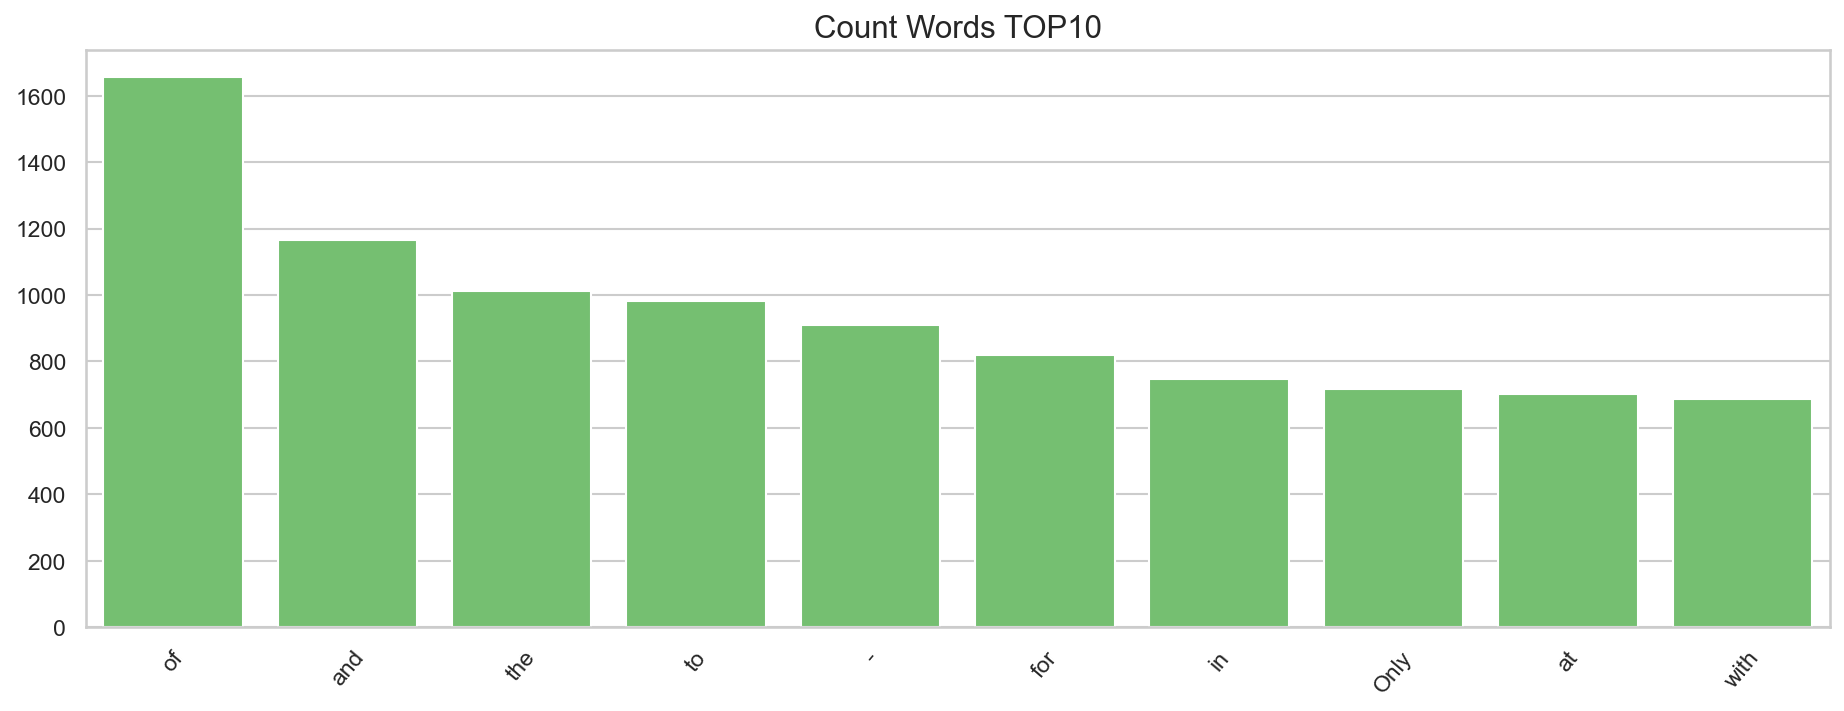

In [27]:
plt.figure(figsize=(15,5), dpi=150)
sns.barplot(x=[word[0] for word in top_ten_words], y=[word[1] for word in top_ten_words], color='g')
plt.xticks(rotation=50)
plt.title('Count Words TOP10', fontsize=15)
# Save Figure:
# plt.savefig(f"figures/EDA/{name}.png", transparent=True, bbox_inches='tight', dpi=200)
plt.show()

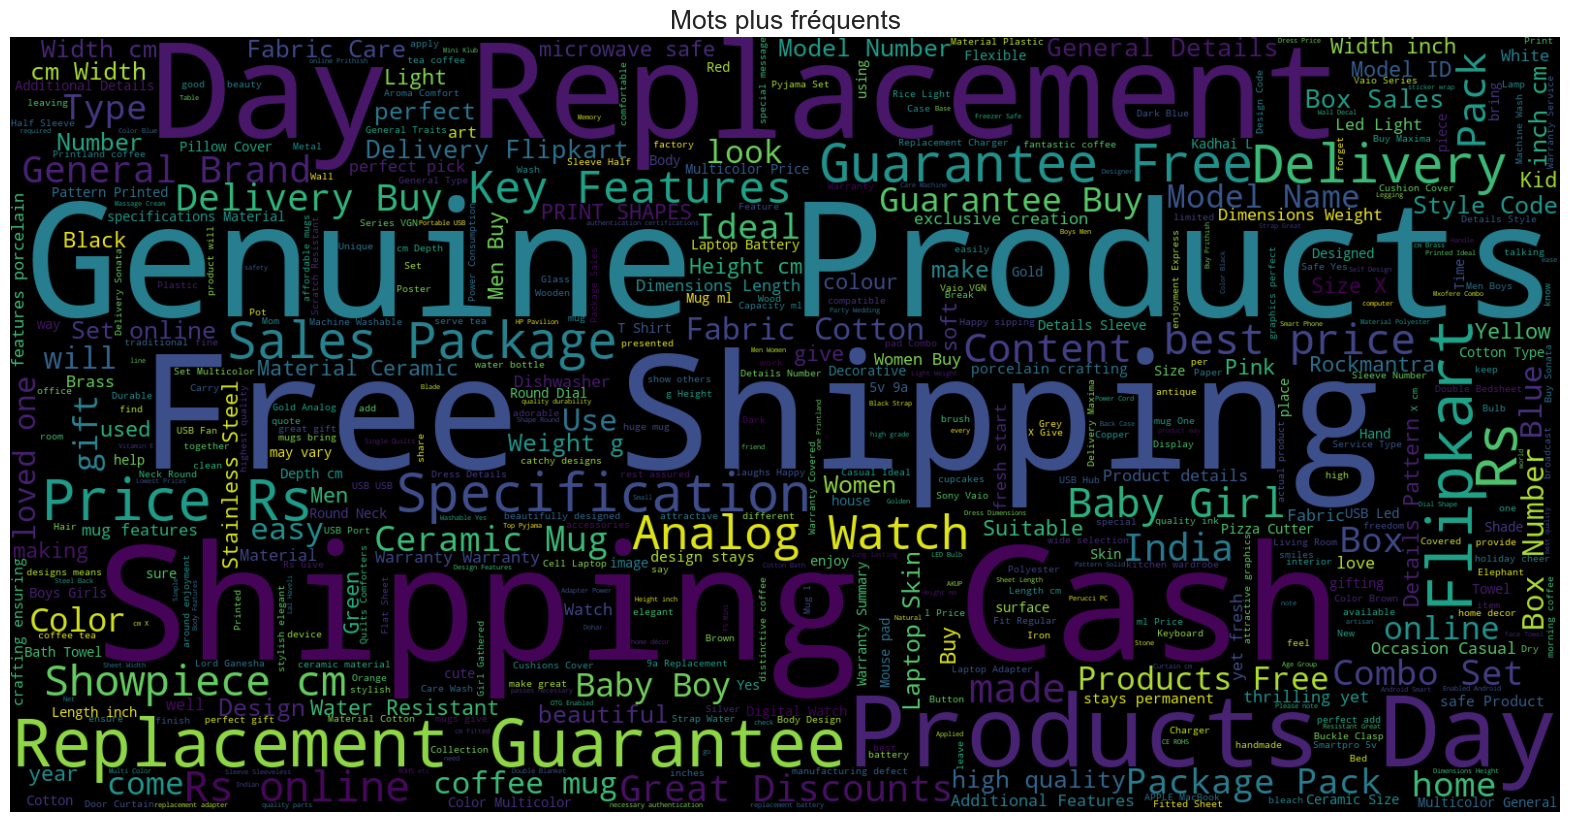

In [31]:
from wordcloud import WordCloud
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Mots plus fréquents', fontsize=19)
plt.show()

In [32]:
# dix éléments au hasard
random_text_sample = text_data_reduced["description"].sample(1000)

In [33]:
random_text_sample = ' '.join(random_text_sample.values)

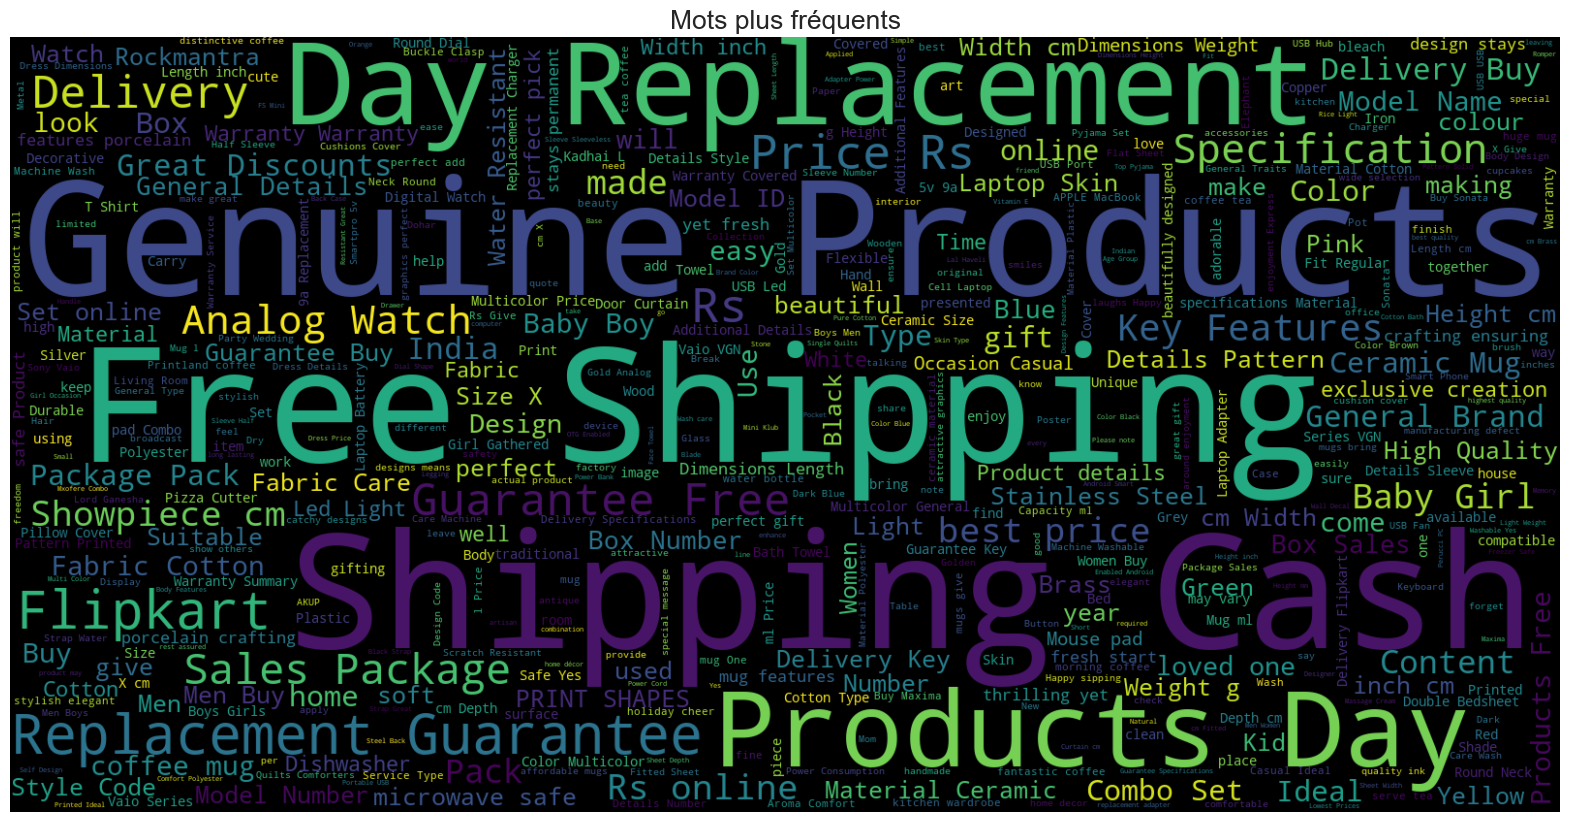

In [34]:
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(random_text_sample)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Mots plus fréquents', fontsize=19)
plt.show()

Selon les word cloud, nous remarquons que les mots les plus fréquent sont : 
- des mots relatifs à la qualité des produits. 
- des mots relatifs au mode de livraison ici Free Shipping. 
- des mots relatifs au mode de paiements et au prix des produits. 
- des mots relatifs aux caractéristiques des produits. 

**Coclusion**

Après l'Analyse Exploratoire , un nettoyage du texte est nécessaire afin, les étapes classiques de pre-processing : 

- `Tokenization` : Décomposer le text en Tokens (Jetons) individuels. 
- `Stopword` : suppression des mots qui n'apporte pas d'infromation pour l'analyse, ceci permetras de réduire le bruit dans les données. 
- `Stemming` : concerver la racine des mots, suppression des suffixes, préfixes. 
- `Lemmatization` : concerver la forme canonique d'un mot, l'infinitif pour un verbe et le singulier pour un mots au pluriel come exemple, la Lemmitization nécessite l'utilisation d'un dictionnaire pour obtenir la forme de base du mot. 
- `Cleaning` : suppression de tous les caractères indésirables, chiffres, caractères spéciaux...


D'autre techniques sont utilisées pour normaliser plus les mots d'un texte, en général selon le contexte de l'analyse les opérations précédentes sont souvent combinées de diverses manières pour répondre à la problématique de départ. 

### Les catégories de produits

Comme nous l'avons constaté précédemment le contenu de la  colonne **`product_category_tree`** est comme suite : 

["**Home Furnishing** >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]

["**Baby Care** >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]

dans cet exemple la catégorie du produit correspond à la première chaîne de caractères qui se situe après les caractères `["` et qui s'arrête au caractère ` >>`

Nous utiliseron la librairie **`Regular expression operations`** afin d'extraire la catégorie du produit, et enregistrr les résultat dans une colonne **`category_global`**

Une solution pour construire notre expression est d'utiliser le site (https://regex101.com/)

**Regular Expression**

**TESTS** : Début

In [35]:
test = text_data_reduced['product_category_tree'][9]
pattern = "^\[\"(.+)\"\]$"
match = re.match(pattern, test)

In [36]:
test

'["Watches >> Wrist Watches >> TAG Heuer Wrist Watches"]'

In [37]:
match.group(1)

'Watches >> Wrist Watches >> TAG Heuer Wrist Watches'

In [38]:
str_test = match.group(1)

In [39]:
str_test.split(" >> ")[2]

'TAG Heuer Wrist Watches'

In [40]:
values = text_data_reduced['product_category_tree']

In [41]:
values[0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

**TESTS** : Fin

**Split des Catégories**

In [42]:
# regular expression : 
pattern = "^\[\"(.+)\"\]$"

#---regex définitions----: 

# ^\[\" : pour délimiter les string Commençant par ["
# "\]$ : pour délimiter les string finissant par "]
# () : pour capturer un groupe donner 
# . : tout caractère autre que le caractère nouvelle linge. 
# + : Un ou plusieurs token consécutifs.

#-----Variable catégorie vide------:
text_data_reduced['product_category'] = ''

# Itérations dans les valeurs de chaque ligne
for i in range(len(values)):
    match_ = re.match(pattern, values[i])
    text_data_reduced.loc[i,'product_category'] = match_.group(1)
    text_data_reduced.loc[i,'product_category'] = text_data_reduced.loc[i,'product_category']

# # text_data_reduced['product_category'] = text_data_reduced['product_category'].split(" >> ")
# for i in range(len(values)):
#     text_data_reduced.loc[i, 'product_category'] = text_data_reduced.loc[i, 'product_category'][0]


In [43]:
# Extraction des catégories Ctégories Niveau 1 
text_data_reduced['product_category_1'] = ''
for i in range(len(values)):
    text_data_reduced.loc[i, 'product_category_1'] = text_data_reduced.loc[i,'product_category'].split(" >> ")[0]

In [44]:
# Ctégories Niveau 2 text_data_reduced 
text_data_reduced['product_category_2'] = ''
for i in range(len(values)):
    text_data_reduced.loc[i, 'product_category_2'] = text_data_reduced.loc[i,'product_category'].split(" >> ")[1]

In [45]:
# Ctégories Niveau 3 

"""
Il existe des lignes où le nombre de catégories est inférieur à 3,
dans ce cas on attribut le deuxième élément de la liste.
""" 

text_data_reduced['product_category_3'] = ''
for i in range(len(values)):
    if len(text_data_reduced.loc[i,'product_category'].split(" >> ")) < 3:
        text_data_reduced.loc[i, 'product_category_3'] = text_data_reduced.loc[i,'product_category'].split(" >> ")[1]
    else:
        text_data_reduced.loc[i, 'product_category_3'] = text_data_reduced.loc[i,'product_category'].split(" >> ")[2]

In [46]:
text_data_reduced.head(3)


uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   

                              product_specifications  \
0  {"product_specification"=>[{"key"=>"Brand", "v...   
1  {"product_specification"=>[{"key"=>"Machine Wa...   
2  {"product_specification"=>[{"key"=>"Material",...   

                                    product_category product_category_1  \
0  Home Furnishing >> Curtains & Accessories >> C...    Home Furnishing   
1  Baby Care >> Baby Bath & Skin >> Baby Bath Tow...          Baby Care   
2  Baby Care >> Baby Bath & Skin >> Baby Bath Tow...          Baby Care   

       product_category_2 product_category_3  
0  Curtains & Accessories           Curtains  
1        Baby Bath & Skin   Baby Bath Towels  
2        Baby Bath & Skin   Baby Bath Towels

In [47]:
for col in text_data_reduced.columns:
    print('*'*20)
    print(f"Les 3 premiers  éléments de la colonne : {col}")
    print(*text_data_reduced[col][:3], sep = "\n")

********************
Les 3 premiers  éléments de la colonne : uniq_id
55b85ea15a1536d46b7190ad6fff8ce7
7b72c92c2f6c40268628ec5f14c6d590
64d5d4a258243731dc7bbb1eef49ad74
********************
Les 3 premiers  éléments de la colonne : product_name
Elegance Polyester Multicolor Abstract Eyelet Door Curtain
Sathiyas Cotton Bath Towel
Eurospa Cotton Terry Face Towel Set
********************
Les 3 premiers  éléments de la colonne : product_category_tree
["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]
["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]
["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]
********************
Les 3 premiers  éléments de la colonne : image
55b85ea15a1536d46b7190ad6fff8ce7.jpg
7b72c92c2f6c40268628ec5f14c6d590.jpg
64d5d4a258243731dc7b

In [48]:
text_data_reduced['product_category_1'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [49]:
text_data_reduced['product_category_1'].value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: product_category_1, dtype: int64

In [50]:
text_data_reduced['product_category_2'].unique()

array(['Curtains & Accessories', 'Baby Bath & Skin', 'Bed Linen',
       'Wrist Watches', 'Living Room Furnishing', 'Bath Linen',
       'Candles & Fragrances', 'Tableware & Cutlery', 'Lighting',
       'JMD Home Furnishing', 'Infant Wear', "Kripa's Home Furnishing",
       'Hair Care', 'Coffee Mugs', 'Network Components',
       'Tablet Accessories', 'Cookware', 'Laptop Accessories', 'Makeup',
       'Combos and Kits', 'Feeding & Nursing', 'Baby Bedding',
       'Kitchen & Dining Linen', 'Containers & Bottles',
       'Consumables & Disposables', 'Wall Decor & Clocks',
       'Table Decor & Handicrafts', 'Flowers, Plants & Vases', 'Software',
       'Showpieces', 'Furniture & Furnishings',
       'Decorative Lighting & Lamps', 'Baby Grooming',
       'Computer Peripherals', 'Cushions, Pillows & Covers', 'Storage',
       'Health Care', 'Body and Skin Care', 'Kitchen Tools',
       'TRUE Home Decor & Festive Needs', 'Living', 'Showpiece',
       'Bar & Glassware', 'Fragrances', "Women'

In [51]:
text_data_reduced['product_category_2'].value_counts()

Wrist Watches                      149
Laptop Accessories                  87
Infant Wear                         84
Coffee Mugs                         74
Showpieces                          71
Bed Linen                           65
Fragrances                          65
Network Components                  49
Cookware                            27
Table Decor & Handicrafts           27
Combos and Kits                     24
Wall Decor & Clocks                 22
Bath Linen                          21
Curtains & Accessories              19
Makeup                              18
Baby Bedding                        15
Body and Skin Care                  15
Baby & Kids Gifts                   15
Baby Bath & Skin                    14
Kitchen Tools                       14
Kitchen & Dining Linen              14
Decorative Lighting & Lamps         14
Containers & Bottles                13
Cushions, Pillows & Covers          13
Hair Care                            9
Feeding & Nursing        

In [52]:
text_data_reduced['product_category_3'].unique()

array(['Curtains', 'Baby Bath Towels', 'Bedsheets',
       'Maserati Time Wrist Watches', 'Camerii Wrist Watches',
       'T STAR Wrist Watches', 'Alfajr Wrist Watches',
       'TAG Heuer Wrist Watches', 'Calibro Wrist Watches',
       'Cartier Wrist Watches', 'Lois Caron Wrist Watches',
       'Titan Wrist Watches', 'Srushti Art Jewelry Wrist Watches',
       'Escort Wrist Watches', 'Jack klein Wrist Watches',
       'North Moon Wrist Watches', 'Franck Bella Wrist Watches',
       'Ridas Wrist Watches', 'Skmei Wrist Watches', 'Now Wrist Watches',
       'fastrack Wrist Watches', 'Disney Wrist Watches',
       'Vizion Wrist Watches', 'Elantra Wrist Watches',
       'Marvel Wrist Watches', 'Lenco Wrist Watches',
       "D'Signer Wrist Watches", 'Diwan Sets', 'Duvet Covers',
       'Bath Mats', 'Home Fragrances', 'Jug, Glass & Tray Sets', 'Bulbs',
       'JMD Printed Cushions Cover (Pack of 2, 40 cm*40 ...',
       "Baby Girls' Clothes",
       "Kripa's Printed Cushions Cover (Pack of 2,

In [53]:
text_data_reduced['product_category_3'].value_counts()

Deodorants                   65
Blankets, Quilts & Dohars    57
Routers                      49
Baby Girls' Clothes          49
USB Gadgets                  38
                             ..
Portable Projectors           1
Changing Tables               1
Titan Wrist Watches           1
Table Linen Sets              1
Strollers & Prams             1
Name: product_category_3, Length: 243, dtype: int64

**Niveau 1**

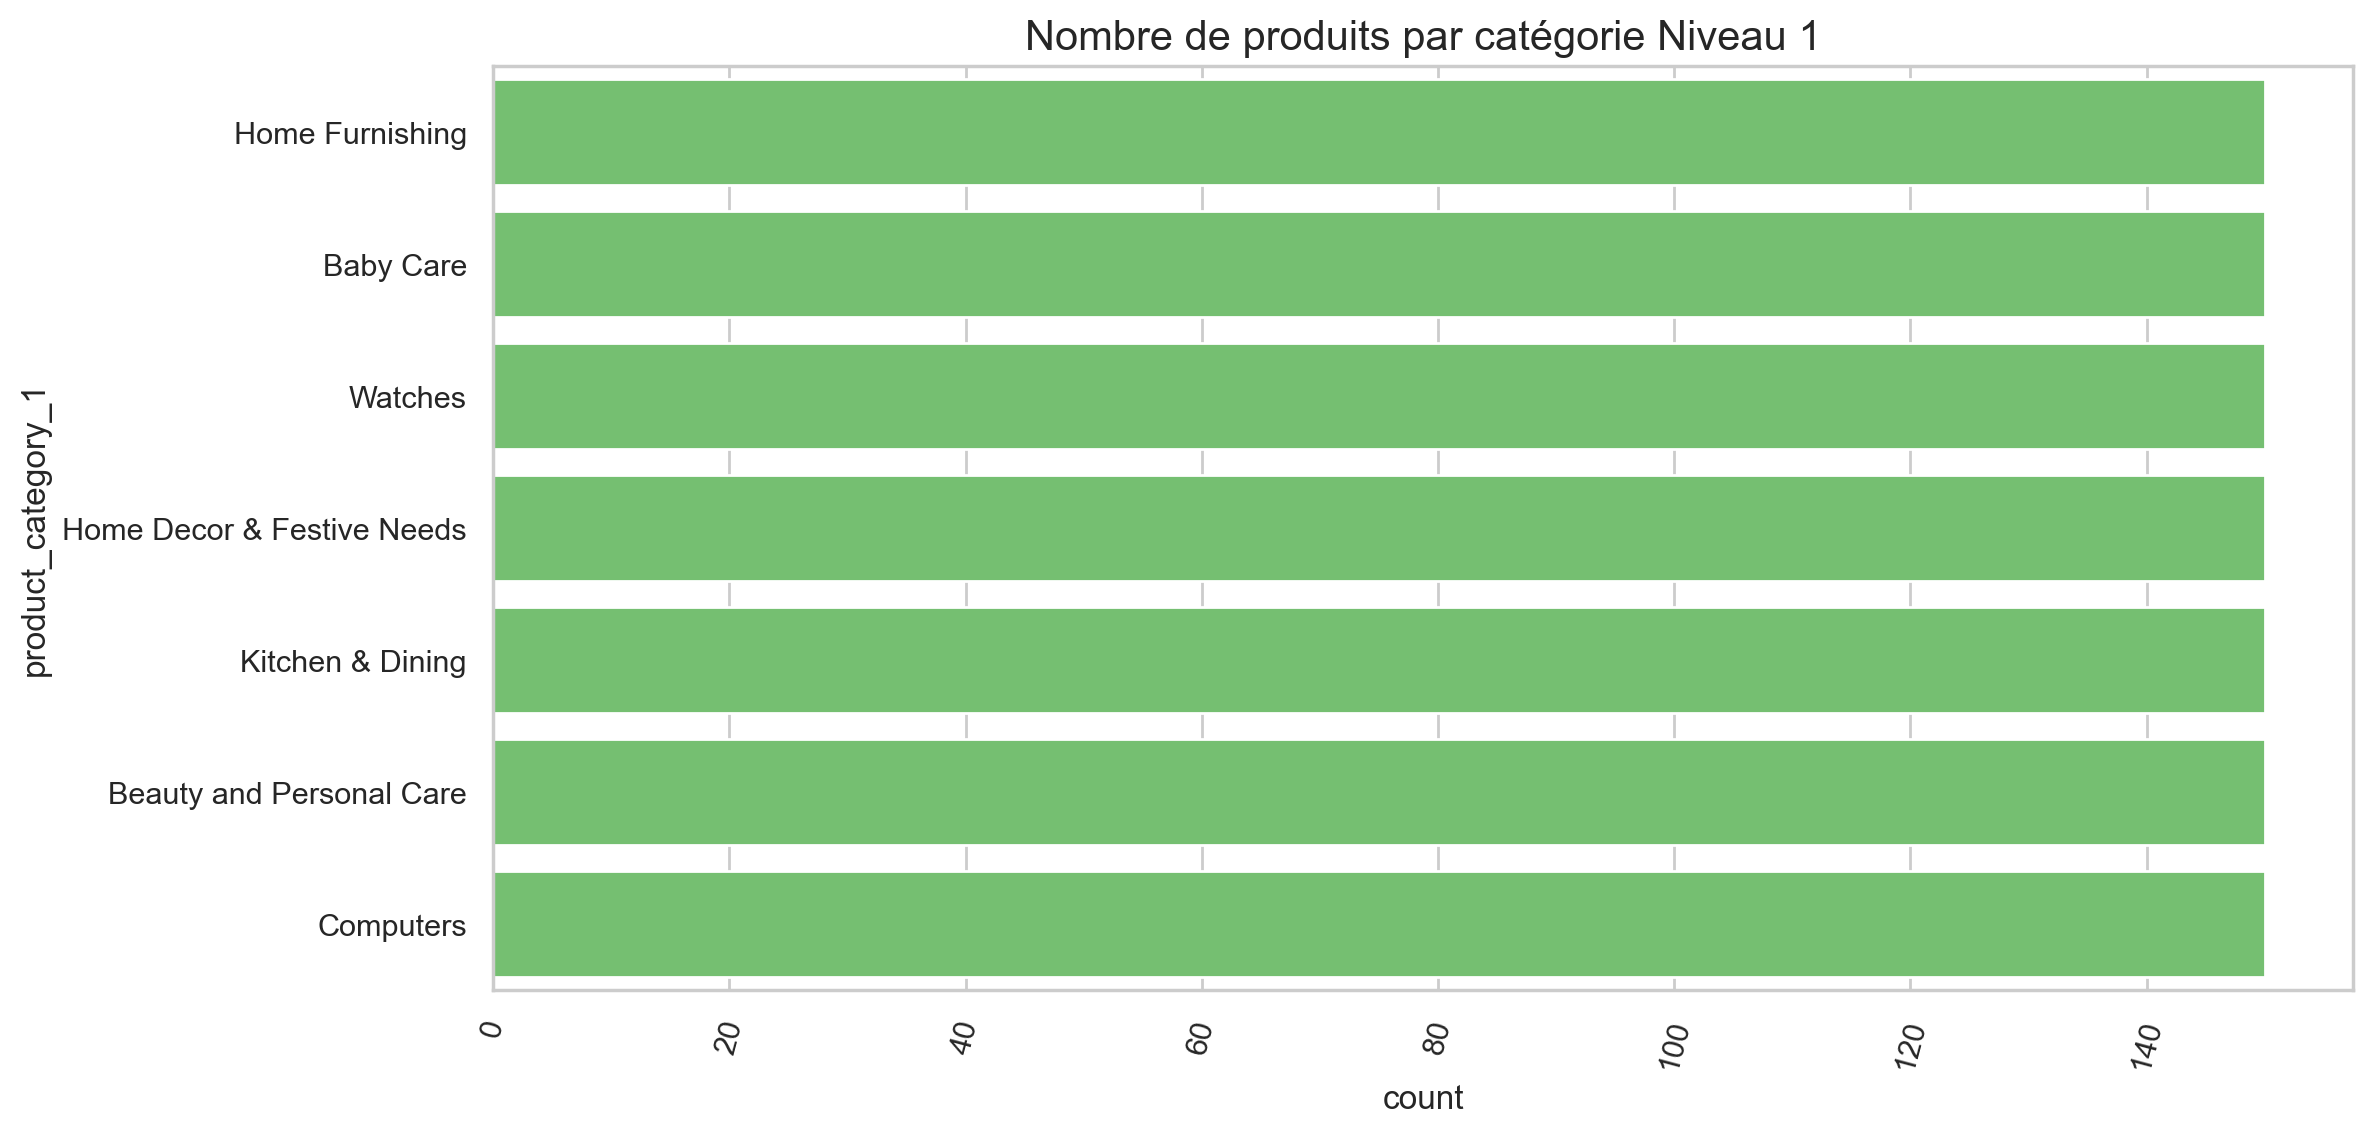

In [54]:
fig = plt.figure(figsize=(12, 6), dpi=200)
data_plot = text_data_reduced['product_category_1']

sns.countplot(y=data_plot, order = text_data_reduced['product_category_1'].value_counts(normalize=True).index, color='g')
plt.xticks(rotation=75);
plt.title('Nombre de produits par catégorie Niveau 1', fontsize=15)
# Save Figure:
# plt.savefig(f"figures/EDA/{name}.png", transparent=True, bbox_inches='tight', dpi=200)
plt.show()

**Niveau 2**

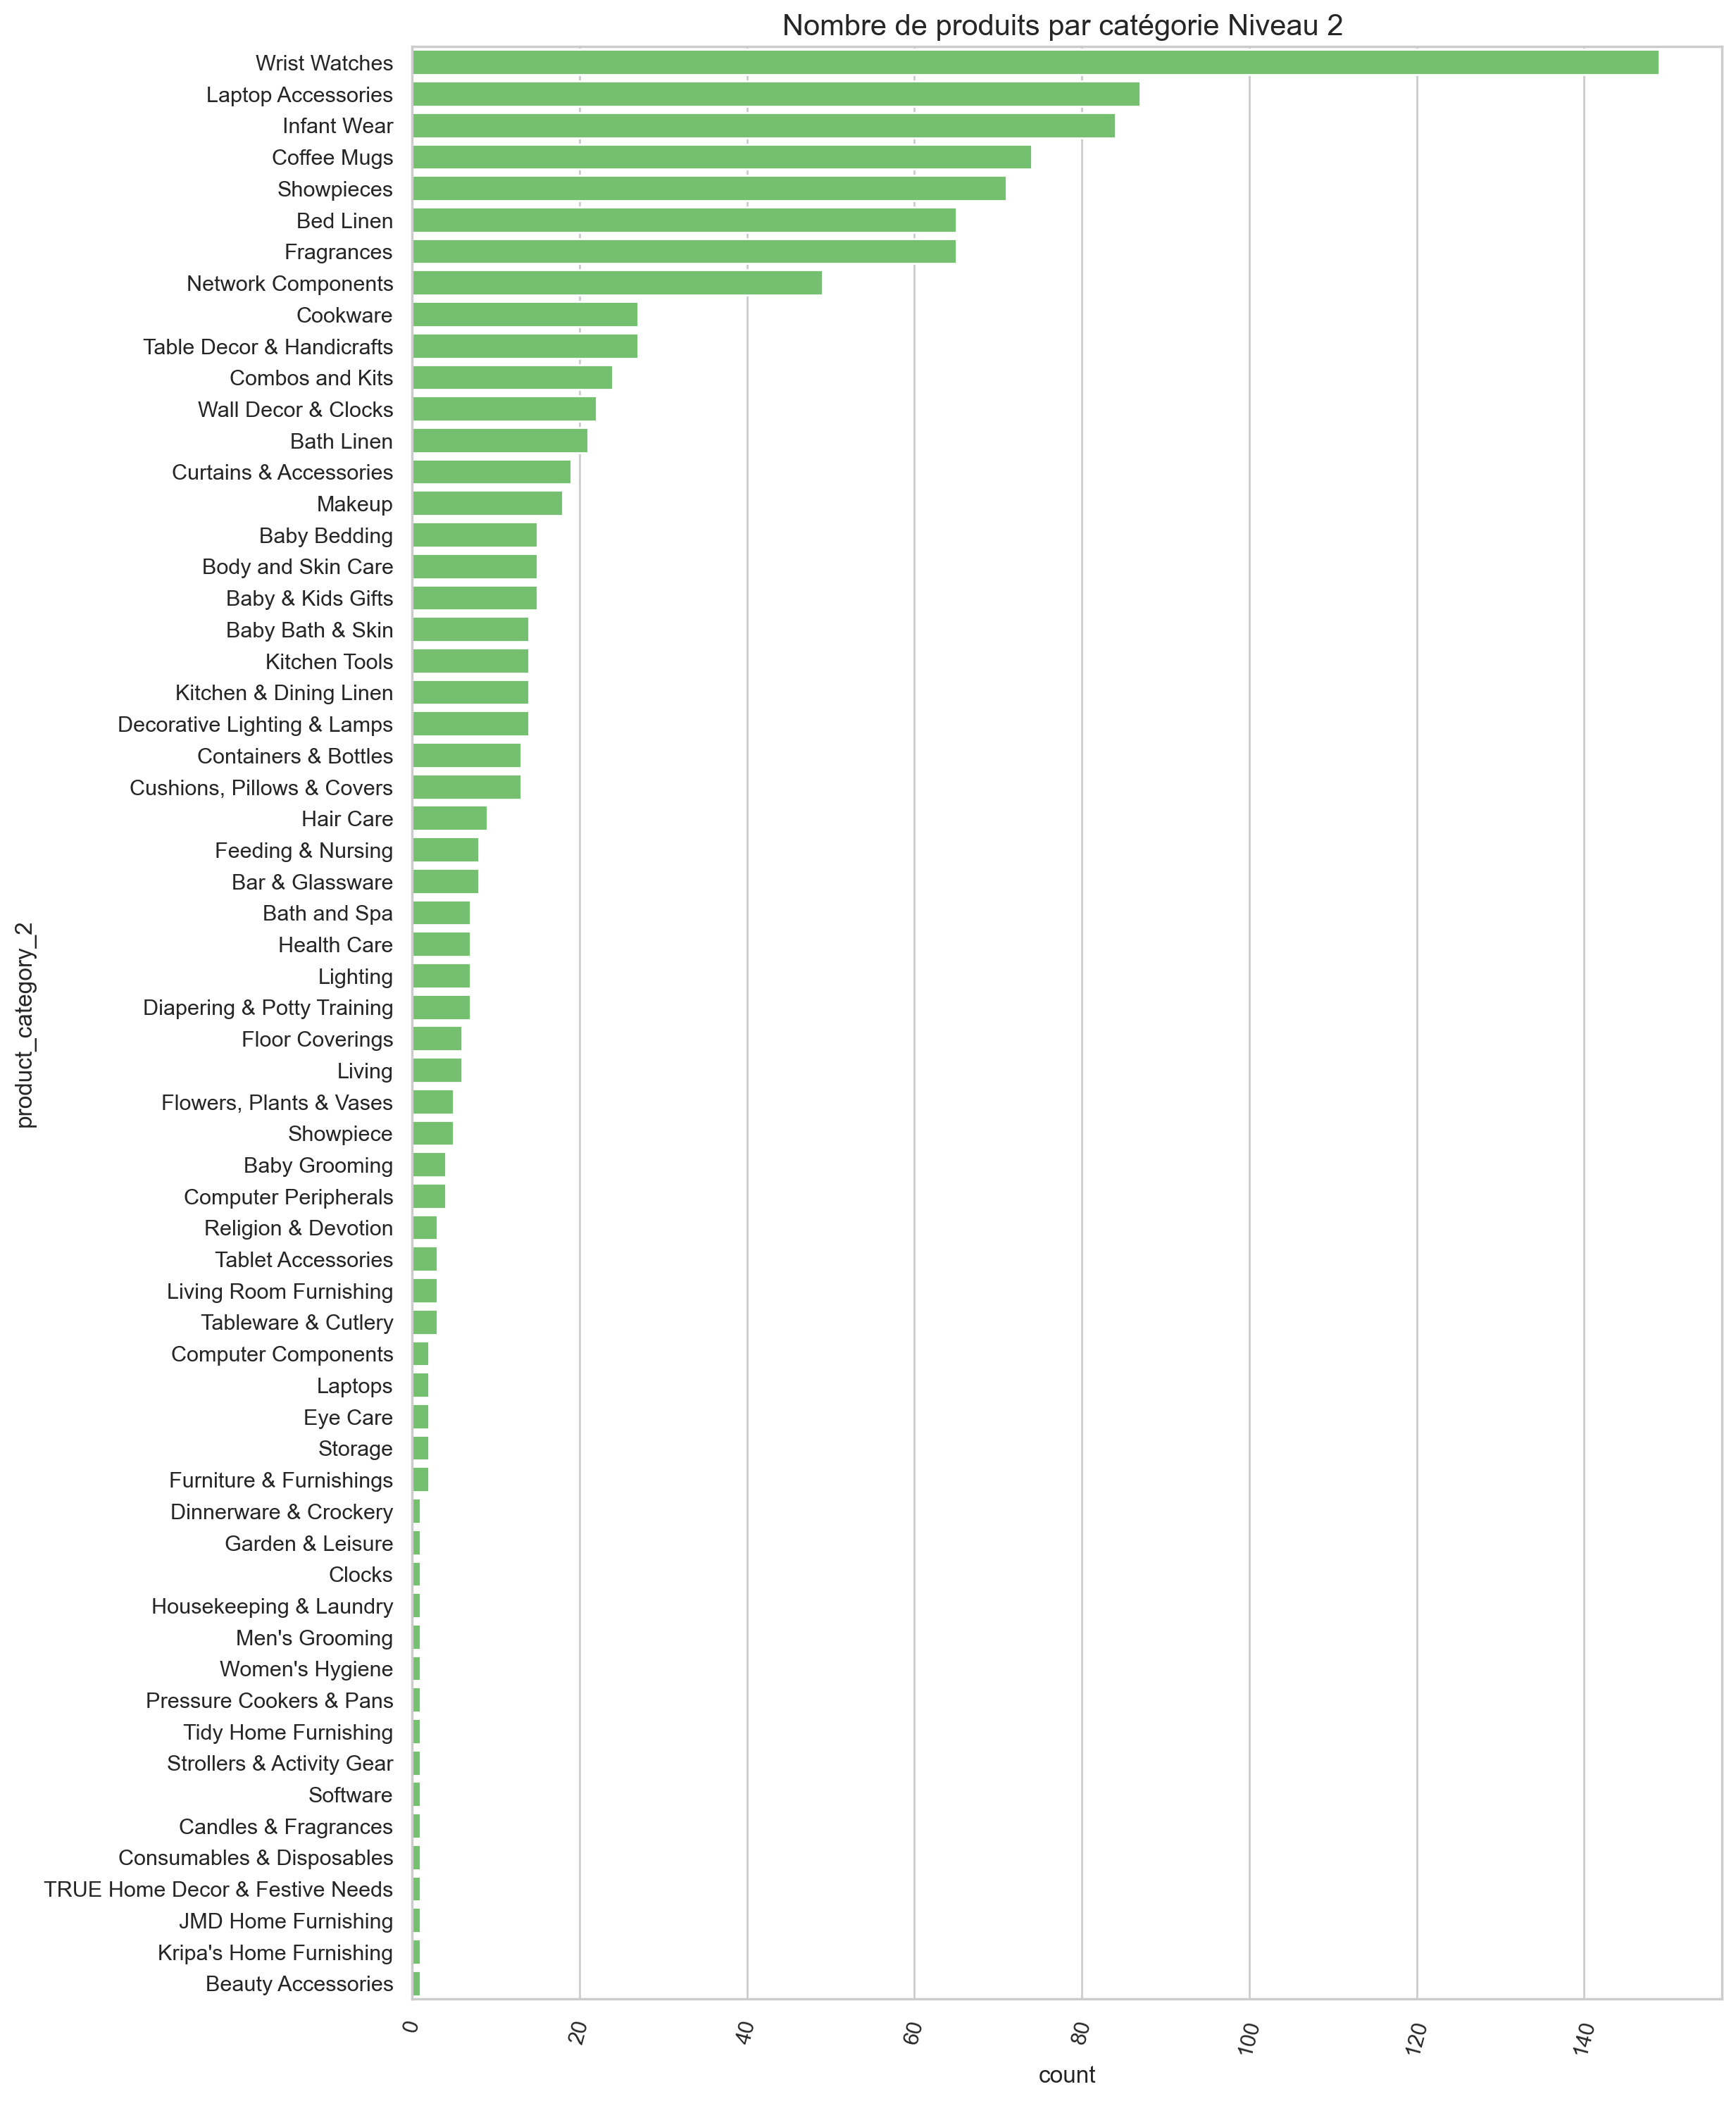

In [55]:
fig = plt.figure(figsize=(12, 18), dpi=200)
data_plot = text_data_reduced['product_category_2']

sns.countplot(y=data_plot, order = text_data_reduced['product_category_2'].value_counts(normalize=True).index, color='g')
plt.xticks(rotation=75);
plt.title('Nombre de produits par catégorie Niveau 2 ', fontsize=15)
# Save Figure:
# plt.savefig(f"figures/EDA/{name}.png", transparent=True, bbox_inches='tight', dpi=200)
plt.show()

**Niveau 3**

`Le graphique pour le Niveau 3 n'est pas lisible `

# Pré-traitement du texte

In [56]:
text_data_reduced.columns

Index(['uniq_id', 'product_name', 'product_category_tree', 'image',
       'description', 'product_specifications', 'product_category',
       'product_category_1', 'product_category_2', 'product_category_3'],
      dtype='object')

In [57]:
colum_text_data = ['uniq_id', 'product_name','description','product_category_1', 'image']
data_to_analize = text_data_reduced[colum_text_data]
data_to_analize.head()

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                         description product_category_1  \
0  Key Features of Elegance Polyester Multicolor ...    Home Furnishing   
1  Specifications of Sathiyas Cotton Bath Towel (...          Baby Care   
2  Key Features of Eurospa Cotton Terry Face Towe...          Baby Care   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...    Home Furnishing   
4  Key Features of Jaipur Print Cotton Floral Kin...    Home Furnishing   

                                  image  
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  
1  7b72c92c2f6c40268628ec5f14c6d590.jpg  
2  64d5d4a258243731dc7bbb1eef49ad74.jpg  
3  d4684dcdc759dd9cdf41504698d737d8.jpg  
4  6325b6870c54cd47be6ebfbffa620ec7.jpg

In [58]:
# data_to_analize
df = data_to_analize
path = "./data/cleaned/"
filename = "cleaned_data_to_analize_dataset.csv"
columns_to_save = list(data_to_analize.columns)

# Save
save_transformed_df(df, path, filename, columns_to_save)

In [59]:
for col in data_to_analize.columns:
    print('*'*20)
    print(f"Les 3 premiers  éléments de la colonne : {col}")
    print(*data_to_analize[col][:3], sep = "\n")

********************
Les 3 premiers  éléments de la colonne : uniq_id
55b85ea15a1536d46b7190ad6fff8ce7
7b72c92c2f6c40268628ec5f14c6d590
64d5d4a258243731dc7bbb1eef49ad74
********************
Les 3 premiers  éléments de la colonne : product_name
Elegance Polyester Multicolor Abstract Eyelet Door Curtain
Sathiyas Cotton Bath Towel
Eurospa Cotton Terry Face Towel Set
********************
Les 3 premiers  éléments de la colonne : description
Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal at

## NLTK

In [60]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [61]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [62]:
# Initialisations : stopwords-----words------lemmatizer
stopwords = nltk.corpus.stopwords.words('english')
words = set(nltk.corpus.words.words())
lemmatizer = WordNetLemmatizer()

Les différentes étape : 
- ponctuation
- digits
- Lowercase
- Tokenization
- Stop words
- Ponctuation

In [63]:
len(words)

235892

In [64]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [65]:
# Ajout du caractère � qui désigne un caractère non connu
punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~�'

In [66]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

`nltk.tokenize.word_tokenize` : est une fonction de la libraire NLTK qui segmente un texte en une liste de mots ou de tokens (jetons) elle suit le processus suivant : 

- Split du texte brut est divisé en phrase à l'aide de la fonction `sent_tokenize()`.
- Chaque phrase est découpé en mots ou tokens à l'aide de la fonction `word_tokenize()`. 
- Puis la fonction renvoie la `liste des tokens`. 

In [67]:
sentence = data_to_analize['description'][1000]
print(sentence)

Key Features of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container Airtight Pack of 6,Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) Price: Rs. 2,145 Flexible Silicone Seal Ensures Precision Lid Fitting.Large Locking Hinges For Easy Open And Closing Movement.Fridge And Freezer Safe,Specifications of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) General Brand Lock&Lock Model Number HPL816X3,HPL806X2,HPL836 Disposable No Model Name Kitchen Material Polypropylene Airtight Yes Capacity 5.5 L Container Type Multi-purpose Storage Container Color Clear In the box Sales Package 6 CONTAINER Pack of 6 Warranty Covered in Warranty Manufacturing Defects Warranty Summary 1 year warranty on manufacturing defects. Warranty Service Type Customer Care Not Covered in Warranty Accidental Damages


In [68]:
def lower_list_words_cleaning(sentence) :
    lower_sentence = "".join([i.lower() for i in sentence])
    return lower_sentence

In [69]:
sentence = lower_list_words_cleaning(sentence)
print('\033[1mPhrase de base :\n\033[0m'+data_to_analize['description'][1000], sep = "\n\n")
print('\033[1mPhrase nettoyée :\n\033[0m'+ sentence,sep = "\n\n")

Phrase de base :
Key Features of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container Airtight Pack of 6,Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) Price: Rs. 2,145 Flexible Silicone Seal Ensures Precision Lid Fitting.Large Locking Hinges For Easy Open And Closing Movement.Fridge And Freezer Safe,Specifications of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) General Brand Lock&Lock Model Number HPL816X3,HPL806X2,HPL836 Disposable No Model Name Kitchen Material Polypropylene Airtight Yes Capacity 5.5 L Container Type Multi-purpose Storage Container Color Clear In the box Sales Package 6 CONTAINER Pack of 6 Warranty Covered in Warranty Manufacturing Defects Warranty Summary 1 year warranty on manufacturing defects. Warranty Service Type Customer Care Not Covered in Warranty Accidental Damages
Phrase nettoyée :
key features of lock&lock kitchen  - 5.5 l polypropylene multi-p

In [70]:
def tokenizer_sentence(sentence) :

    clean_sentence = sentence.replace('    ', ' ').replace('     ', ' ').replace('&', ' ').replace(',', ' ').replace('.', ' ')
    clean_sentence = clean_sentence.replace('-', ' ')
    word_tokens = word_tokenize(clean_sentence)
    return word_tokens

In [71]:
sentence = tokenizer_sentence(sentence)
print('\033[1mPhrase de base :\n\033[0m'+data_to_analize['description'][1000], sep = "\n\n")
print('\033[1mPhrase nettoyée :\n\033[0m', sep = "\n\n")
print(sentence)

Phrase de base :
Key Features of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container Airtight Pack of 6,Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) Price: Rs. 2,145 Flexible Silicone Seal Ensures Precision Lid Fitting.Large Locking Hinges For Easy Open And Closing Movement.Fridge And Freezer Safe,Specifications of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) General Brand Lock&Lock Model Number HPL816X3,HPL806X2,HPL836 Disposable No Model Name Kitchen Material Polypropylene Airtight Yes Capacity 5.5 L Container Type Multi-purpose Storage Container Color Clear In the box Sales Package 6 CONTAINER Pack of 6 Warranty Covered in Warranty Manufacturing Defects Warranty Summary 1 year warranty on manufacturing defects. Warranty Service Type Customer Care Not Covered in Warranty Accidental Damages
Phrase nettoyée :

['key', 'features', 'of', 'lock', 'lock', 'kitchen', '5', '5', 

In [72]:
def punctuation_cleaning(sentence) :
    punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~�'
    clean_sentence = [i for i in sentence if i not in punctuation]
    return clean_sentence

In [73]:
sentence = punctuation_cleaning(sentence)
print('\033[1mPhrase de base :\n\033[0m'+data_to_analize['description'][1000], sep = "\n\n")
print('\033[1mPhrase nettoyée :\n\033[0m',sep = "\n\n")
print(sentence)

Phrase de base :
Key Features of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container Airtight Pack of 6,Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) Price: Rs. 2,145 Flexible Silicone Seal Ensures Precision Lid Fitting.Large Locking Hinges For Easy Open And Closing Movement.Fridge And Freezer Safe,Specifications of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) General Brand Lock&Lock Model Number HPL816X3,HPL806X2,HPL836 Disposable No Model Name Kitchen Material Polypropylene Airtight Yes Capacity 5.5 L Container Type Multi-purpose Storage Container Color Clear In the box Sales Package 6 CONTAINER Pack of 6 Warranty Covered in Warranty Manufacturing Defects Warranty Summary 1 year warranty on manufacturing defects. Warranty Service Type Customer Care Not Covered in Warranty Accidental Damages
Phrase nettoyée :

['key', 'features', 'of', 'lock', 'lock', 'kitchen', '5', '5', 

In [74]:
def digits_cleaning(sentence) :
    clean_sentence = [i for i in sentence if not i.isdigit()]
    return clean_sentence

In [75]:
sentence = digits_cleaning(sentence)
print('\033[1mPhrase de base :\n\033[0m'+data_to_analize['description'][1000], sep = "\n\n")
print('\033[1mPhrase nettoyée :\n\033[0m',sep = "\n\n")
print(sentence)

Phrase de base :
Key Features of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container Airtight Pack of 6,Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) Price: Rs. 2,145 Flexible Silicone Seal Ensures Precision Lid Fitting.Large Locking Hinges For Easy Open And Closing Movement.Fridge And Freezer Safe,Specifications of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) General Brand Lock&Lock Model Number HPL816X3,HPL806X2,HPL836 Disposable No Model Name Kitchen Material Polypropylene Airtight Yes Capacity 5.5 L Container Type Multi-purpose Storage Container Color Clear In the box Sales Package 6 CONTAINER Pack of 6 Warranty Covered in Warranty Manufacturing Defects Warranty Summary 1 year warranty on manufacturing defects. Warranty Service Type Customer Care Not Covered in Warranty Accidental Damages
Phrase nettoyée :

['key', 'features', 'of', 'lock', 'lock', 'kitchen', 'l', 'poly

In [76]:
def alpha_cleaning(sentence) :
    clean_sentence = [i for i in sentence if i.isalpha()]
    return clean_sentence

In [77]:
sentence = alpha_cleaning(sentence)
print('\033[1mPhrase de base :\n\033[0m'+data_to_analize['description'][1000], sep = "\n\n")
print('\033[1mPhrase nettoyée :\n\033[0m',sep = "\n\n")
print(sentence)

Phrase de base :
Key Features of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container Airtight Pack of 6,Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) Price: Rs. 2,145 Flexible Silicone Seal Ensures Precision Lid Fitting.Large Locking Hinges For Easy Open And Closing Movement.Fridge And Freezer Safe,Specifications of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) General Brand Lock&Lock Model Number HPL816X3,HPL806X2,HPL836 Disposable No Model Name Kitchen Material Polypropylene Airtight Yes Capacity 5.5 L Container Type Multi-purpose Storage Container Color Clear In the box Sales Package 6 CONTAINER Pack of 6 Warranty Covered in Warranty Manufacturing Defects Warranty Summary 1 year warranty on manufacturing defects. Warranty Service Type Customer Care Not Covered in Warranty Accidental Damages
Phrase nettoyée :

['key', 'features', 'of', 'lock', 'lock', 'kitchen', 'l', 'poly

In [78]:
def clean_stop_words(sentence) :
    clean_sentence = [i for i in sentence if i not in stopwords]
    clean_sentence = [w for w in clean_sentence if len(w) > 2]
    return clean_sentence

In [79]:
sentence = clean_stop_words(sentence)
print('\033[1mPhrase de base :\n\033[0m'+data_to_analize['description'][1000], sep = "\n\n")
print('\033[1mPhrase nettoyée :\n\033[0m', sep = "\n\n")
print(sentence)

Phrase de base :
Key Features of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container Airtight Pack of 6,Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) Price: Rs. 2,145 Flexible Silicone Seal Ensures Precision Lid Fitting.Large Locking Hinges For Easy Open And Closing Movement.Fridge And Freezer Safe,Specifications of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) General Brand Lock&Lock Model Number HPL816X3,HPL806X2,HPL836 Disposable No Model Name Kitchen Material Polypropylene Airtight Yes Capacity 5.5 L Container Type Multi-purpose Storage Container Color Clear In the box Sales Package 6 CONTAINER Pack of 6 Warranty Covered in Warranty Manufacturing Defects Warranty Summary 1 year warranty on manufacturing defects. Warranty Service Type Customer Care Not Covered in Warranty Accidental Damages
Phrase nettoyée :

['key', 'features', 'lock', 'lock', 'kitchen', 'polypropylene',

In [80]:
def words_lemmatize(words_list) :
    lemmatizer = WordNetLemmatizer()
    clean_words_list = [lemmatizer.lemmatize(w) for w in words_list]
    return clean_words_list

In [81]:
sentence = words_lemmatize(sentence)
print('\033[1mPhrase de base :\n\033[0m'+data_to_analize['description'][120], sep = "\n\n")
print('\033[1mPhrase nettoyée :\n\033[0m', sep = "\n\n")
print(sentence)

Phrase de base :
Key Features of Quilt India Floral Cushions Cover Width 77 cm,Specifications of Quilt India Floral Cushions Cover (77 cm, Gold) General Brand Quilt India Suitable For Cushions Design Code QUILT_20145 Material Dupion Silk Style Code QUILT_20145 Pattern Floral Color Gold Dimensions Width 30 inch / 77 cm In the Box Number of Contents in Sales Package Pack of 1
Phrase nettoyée :

['key', 'feature', 'lock', 'lock', 'kitchen', 'polypropylene', 'multi', 'purpose', 'storage', 'container', 'airtight', 'pack', 'lock', 'lock', 'kitchen', 'polypropylene', 'multi', 'purpose', 'storage', 'container', 'pack', 'clear', 'price', 'flexible', 'silicone', 'seal', 'ensures', 'precision', 'lid', 'fitting', 'large', 'locking', 'hinge', 'easy', 'open', 'closing', 'movement', 'fridge', 'freezer', 'safe', 'specification', 'lock', 'lock', 'kitchen', 'polypropylene', 'multi', 'purpose', 'storage', 'container', 'pack', 'clear', 'general', 'brand', 'lock', 'lock', 'model', 'number', 'disposable', '

In [82]:
# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec) Sans Lemmatization
def texte_preparation_bow_vectorizer(sentence) :
    sentence_lower = lower_list_words_cleaning(sentence)
    sentence_tokens = tokenizer_sentence(sentence_lower)
    sentence_clean = punctuation_cleaning(sentence_tokens)
    sentence_clean= digits_cleaning(sentence_clean)
    sentence_clean = alpha_cleaning(sentence_clean)
    sentence_clean= clean_stop_words(sentence_clean)
    sentence_clean = ' '.join(elm for elm in sentence_clean)
    return sentence_clean

**Exemple sans lemmatization**

In [84]:
sentence_test = data_to_analize['description'][1032]
cleaned_sentence = texte_preparation_bow_vectorizer(sentence_test)
print('\033[1mPhrase de base :\n\033[0m'+sentence_test, sep = "\n\n")
print('\033[1mPhrase nettoyée Sans Lemmatisation :\n\033[0m', sep = "\n\n")
print(cleaned_sentence)

Phrase de base :
Key Features of PRINT SHAPES mary and max cartoon Laptop Skin with Mouse pad Combo Set Glue Free Removal 15.6 inches Laptop skin Easy to Apply & Scratch Resistant Lamination,PRINT SHAPES mary and max cartoon Laptop Skin with Mouse pad Combo Set (Multicolor) Price: Rs. 329 Print Shapes Laptop skin made on High Quality vinyl sheet is compatible with laptops screen sizes ranging from 14.1 inches to 15.6 inches. Trimning of the skin would be required as per your laptop size. The skins are easy to install & remove without leaving any gum or residue,Specifications of PRINT SHAPES mary and max cartoon Laptop Skin with Mouse pad Combo Set (Multicolor) General Brand PRINT SHAPES Model Name mary and max cartoon Laptop Skin with Mouse pad Suitable_for All types of Laptop Color Multicolor Warranty Warranty Summary No Warranty In the Box Number of Contents in Sales Package Pack of 2
Phrase nettoyée Sans Lemmatisation :

key features print shapes mary max cartoon laptop skin mouse p

In [85]:
# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec) Avec Lemmatisation
def texte_preparation_bow_lemmatization(sentence) :
    sentence_lower  = lower_list_words_cleaning(sentence)
    sentence_tokens = tokenizer_sentence(sentence_lower)
    sentence_clean  = punctuation_cleaning(sentence_tokens)
    sentence_clean  = digits_cleaning(sentence_clean)
    sentence_clean  = alpha_cleaning(sentence_clean)
    sentence_clean  = clean_stop_words(sentence_clean)
    sentence_clean  = words_lemmatize(sentence_clean)
    sentence_clean  = ' '.join(elm for elm in sentence_clean)
    return sentence_clean

**Exemple avec lemmatization**

In [87]:
sentence_test = data_to_analize['description'][1032]
cleaned_sentence = texte_preparation_bow_lemmatization(sentence_test)
print('\033[1mPhrase de base :\n\033[0m'+sentence_test, sep = "\n\n")
print('\033[1mPhrase nettoyée Avec Lemmatisation :\n\033[0m', sep = "\n\n")
print(cleaned_sentence)

Phrase de base :
Key Features of PRINT SHAPES mary and max cartoon Laptop Skin with Mouse pad Combo Set Glue Free Removal 15.6 inches Laptop skin Easy to Apply & Scratch Resistant Lamination,PRINT SHAPES mary and max cartoon Laptop Skin with Mouse pad Combo Set (Multicolor) Price: Rs. 329 Print Shapes Laptop skin made on High Quality vinyl sheet is compatible with laptops screen sizes ranging from 14.1 inches to 15.6 inches. Trimning of the skin would be required as per your laptop size. The skins are easy to install & remove without leaving any gum or residue,Specifications of PRINT SHAPES mary and max cartoon Laptop Skin with Mouse pad Combo Set (Multicolor) General Brand PRINT SHAPES Model Name mary and max cartoon Laptop Skin with Mouse pad Suitable_for All types of Laptop Color Multicolor Warranty Warranty Summary No Warranty In the Box Number of Contents in Sales Package Pack of 2
Phrase nettoyée Avec Lemmatisation :

key feature print shape mary max cartoon laptop skin mouse pad

In [88]:
data_to_analize = data_to_analize.copy()
data_to_analize['description_bow'] = data_to_analize['description'].apply(lambda x : texte_preparation_bow_vectorizer(x))
data_to_analize['description_bow_lem'] = data_to_analize['description'].apply(lambda x : texte_preparation_bow_lemmatization(x))

In [89]:
data_to_analize.head()

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                         description product_category_1  \
0  Key Features of Elegance Polyester Multicolor ...    Home Furnishing   
1  Specifications of Sathiyas Cotton Bath Towel (...          Baby Care   
2  Key Features of Eurospa Cotton Terry Face Towe...          Baby Care   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...    Home Furnishing   
4  Key Features of Jaipur Print Cotton Floral Kin...    Home Furnishing   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                     description_bow  \
0  key features elegance polyester multicolor abs...   
1  specifications sathiyas cotton bath towel bath...   
2  key features eurospa cotton terry face towel s...   
3  key features santosh royal fashion cotton prin...   
4  key features jaipur print cotton floral king s...   

                                 description_bow_lem  
0  key feature elegance polyester multicolor abst...  
1  specification sathiyas cotton bath towel bath ...  
2  key feature eurospa cotton terry face towel se...  
3  key feature santosh royal fashion cotton print...  
4  key feature jaipur print cotton floral king si...

In [90]:
# checking for missing values
data_to_analize.isnull().sum()

uniq_id                0
product_name           0
description            0
product_category_1     0
image                  0
description_bow        0
description_bow_lem    0
dtype: int64

In [91]:
data_to_analize['token_count'] = data_to_analize['description_bow'].apply(lambda x: len(str(x).split(" ")))


In [92]:
data_to_analize['caracter_count'] = data_to_analize['description_bow'].str.len()

In [93]:
print("Longueur moyenne des documents:", data_to_analize['description_bow'].str.len().mean())

Longueur moyenne des documents: 351.0542857142857


In [94]:
print("Longueur min des documents:", data_to_analize['description_bow'].str.len().min())

Longueur min des documents: 64


In [95]:
print("Longueur max des documents:", data_to_analize['description_bow'].str.len().max())

Longueur max des documents: 2520


In [96]:
msk = data_to_analize['description_bow'].str.len() == 64
print(*data_to_analize.loc[msk,'description_bow'])

next steps baby girl layered dress price girls dress girls dress


In [97]:
msk = data_to_analize['description_bow'].str.len() == 2520
print(*data_to_analize.loc[msk,'description_bow'])

key features homeedge solid wood king bed king bed mattress size king bed natural polish homeedge solid wood king bed finish color natural price made order solidwood bed made finest artisans rajasthan bed made perfection beds handicraft products made order manufacturer please make sure bed ordered aware entire product mattress dimension queen size bed mattress dimension king bed kindly check mattress size order bed also polish might slight variation wooden products grains uniform due grains polish might look light dark portions wooden products termite treated gone high level quality check packed specifications homeedge solid wood king bed finish color natural installation demo installation demo details installation demo product done free cost part purchase service partner visit location within business hours delivery product box king bed general brand homeedge delivery condition knock storage included style contemporary modern bed size king upholstery included upholstery type suitable 

In [98]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

In [99]:
data_to_analize['avg_word'] = data_to_analize['description_bow'].apply(lambda x: avg_word(x))

In [100]:
count_stop_words = data_to_analize['description_bow'].apply(lambda x: len([x for x in x.split() if x in stopwords]))
mean_stop_words = count_stop_words.mean()
mean_stop_words

0.0

In [101]:
count_digits = data_to_analize['description_bow'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
mean_digits = count_digits.mean()
mean_digits

0.0

In [102]:
count_upper = data_to_analize['description_bow'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
mean_upper = count_upper.mean()
mean_upper

0.0

In [103]:
freq_top = pd.Series(' '.join(data_to_analize['description_bow']).split()).value_counts()[:20]

In [104]:
freq_top

products          631
free              618
buy               581
delivery          567
shipping          564
genuine           564
cash              564
replacement       559
day               540
flipkart          481
com               473
guarantee         471
online            396
features          395
specifications    371
price             352
watch             330
color             328
mug               327
baby              320
dtype: int64

In [105]:
freq_bottom_up = pd.Series(' '.join(data_to_analize['description_bow']).split()).value_counts()[-60:]

In [106]:
freq_bottom_up

microfibre       1
alphabets        1
illustrations    1
word             1
bullshit         1
playtime         1
sinha            1
grass            1
stroll           1
hop              1
jhabla           1
skip             1
pullover         1
tele             1
sonakshi         1
engineer         1
hues             1
sam              1
variation        1
celebrations     1
serves           1
portions         1
reflects         1
auspicious       1
enlighten        1
uniform          1
mother           1
maxim            1
jaipurcrafts     1
slight           1
lacto            1
aware            1
shirts           1
relaxed          1
ordered          1
beds             1
solidwood        1
festivities      1
techniques       1
authorized       1
brightens        1
beautifying      1
nearby           1
toxic            1
booking          1
mud              1
opt              1
hrs              1
hut              1
lightning        1
termite          1
cancellation     1
knock       

- `Word embeddings` : une méthode pour représenter les mots dans un espace vectoriel, la position du vecteur reflète la signification du mot, les mots similaires sont les mots qui ont des vecteur proches entre eux. sont généralement apprises à partir d'un grand corpus de texte à l'aide de techniques telles que **word2vec** ou **Glove**. 

Word embeddings offrent un moyen plus large de capturer le sens et le contexte des mots dans un corpus, 

`Word embeddings`, `TF-IDF` et `bag-of-words` (bow), sont toutes des techniques utilisées pour convertir des données textuelles sous une forme numériques (vecteurs), elles sont différentes par leur approche et leurs objectifs.

- `bow` : représente les mots sous forme d'une collection, l'ordre et le contexte des mots est ignoré (vecteur de nombre de mots dans chaque document), la dimensionnalité du vecteur est égale à la taille du vocabulaire. une méthode simple et efficace pour des méthodes de classification de documents ou la recherche d'information par exemple. 

- `TF-IDF` (**T**erm **F**requency-**I**nverse **D**ocument **F**requency) : attribuer un poids à chaque mot d'un document en fonction de sa fréquence d'apparition dans le document (fréquence du terme), et de sa rareté dans tous les documents du corpus (fréquence inverse du document). le vecteur qui résulte représente l'importance de chaque mot dans un document par rapport à son importance dans le corpus. de cette manière on réduit l'impact des mots communs (apparissent fréquement dans un corpus) et mettre en évidence les mots spécifiques du corpus.



## Save CSV

In [107]:
data_to_analize.columns

Index(['uniq_id', 'product_name', 'description', 'product_category_1', 'image',
       'description_bow', 'description_bow_lem', 'token_count',
       'caracter_count', 'avg_word'],
      dtype='object')

In [102]:
data_to_analize.describe(include=[np.number])

token_count  caracter_count     avg_word
count  1050.000000     1050.000000  1050.000000
mean     50.234286      351.054286     6.002117
std      46.306604      331.140583     0.419652
min      11.000000       64.000000     4.628571
25%      21.000000      142.000000     5.737817
50%      31.000000      213.000000     5.958333
75%      68.000000      457.750000     6.250000
max     354.000000     2520.000000     8.176471

In [108]:
data_to_vectorize = data_to_analize [['uniq_id','product_category_1', 'image','description_bow','description_bow_lem']]
data_to_vectorize.head()

uniq_id product_category_1  \
0  55b85ea15a1536d46b7190ad6fff8ce7    Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590          Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74          Baby Care   
3  d4684dcdc759dd9cdf41504698d737d8    Home Furnishing   
4  6325b6870c54cd47be6ebfbffa620ec7    Home Furnishing   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                     description_bow  \
0  key features elegance polyester multicolor abs...   
1  specifications sathiyas cotton bath towel bath...   
2  key features eurospa cotton terry face towel s...   
3  key features santosh royal fashion cotton prin...   
4  key features jaipur print cotton floral king s...   

                                 description_bow_lem  
0  key feature elegance polyester multicolor abst...  
1  specification sathiyas cotton bath towel bath ...  
2  key feature eurospa cotton terry face towel se...  
3  key feature santosh royal fashion cotton print...  
4  key feature jaipur print cotton floral king si...

In [109]:
os.listdir("data/cleaned") 

['cleaned_data_to_analize_dataset.csv',
 'cleaned_data_to_vectorize_dataset.csv',
 'special_tokens_map.json',
 'tokenizer.json',
 'tokenizer_config.json',
 'vocab.txt']

In [110]:
# transformed_order_payments_dataset
df = data_to_vectorize
path = "./data/cleaned/"
filename = "cleaned_data_to_vectorize_dataset.csv"
columns_to_save = list(data_to_vectorize.columns)

# Save
save_transformed_df(df, path, filename, columns_to_save)

# Text Data Features Extraction 

In [68]:
path = "./data/cleaned/"
filename = "cleaned_data_to_vectorize_dataset.csv"
data_to_vectorize = pd.read_csv(path + filename)
data_to_vectorize.head()

uniq_id product_category_1  \
0  55b85ea15a1536d46b7190ad6fff8ce7    Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590          Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74          Baby Care   
3  d4684dcdc759dd9cdf41504698d737d8    Home Furnishing   
4  6325b6870c54cd47be6ebfbffa620ec7    Home Furnishing   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                     description_bow  \
0  key features elegance polyester multicolor abs...   
1  specifications sathiyas cotton bath towel bath...   
2  key features eurospa cotton terry face towel s...   
3  key features santosh royal fashion cotton prin...   
4  key features jaipur print cotton floral king s...   

                                 description_bow_lem  
0  key feature elegance polyester multicolor abst...  
1  specification sathiyas cotton bath towel bath ...  
2  key feature eurospa cotton terry face towel se...  
3  key feature santosh royal fashion cotton print...  
4  key feature jaipur print cotton floral king si...

## Bag of words

### Vectorizer Count 

`CountVectorizer` : Convertir une collection de documents texte en une matrice de nombres de tokens, le nombre de features sera égal à la taille du vocabulaire trouvé en analysant les données texte. [Voir guide d'utilisateur](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

In [15]:
# bow : pour bag-of-words, ici ngram_range = (1,1), c'est à dire nous analyserons les mots un par un
# sans lemmatisation
bow = CountVectorizer(max_df=0.95, min_df=1, stop_words='english', ngram_range=(1, 1))
train_bow = bow.fit_transform(data_to_vectorize['description_bow'])

In [17]:
train_bow.shape

(1050, 4662)

In [16]:
# avec lemmatisation
bow_lemm = CountVectorizer(max_df=0.95, min_df=1, stop_words='english', ngram_range=(1, 1))
train_bow_lemmatize = bow_lemm.fit_transform(data_to_vectorize['description_bow_lem'])

In [18]:
train_bow_lemmatize.shape

(1050, 4250)

**save des vecteurs**

In [16]:
# Save des features : 
bow_to_save = train_bow.toarray()
with open('./data/features_extracted/bow_ngram_uni_Features.npy', 'wb') as f:
    np.save(f, bow_to_save, allow_pickle=True)

In [17]:
# Save des features : 
bow_to_save = train_bow_lemmatize.toarray()
with open('./data/features_extracted/bow_lemm_ngram_uni_Features.npy', 'wb') as f:
    np.save(f, bow_to_save, allow_pickle=True)

#### Fine tuning TSNE 

In [24]:
# Initialisations : 

#----------TSNE hyperparam---------------: 
PERPLEX = np.linspace(5, 70, 5, dtype=int)
LR = np.linspace(10, 1000, 5, dtype=int)

#-------n catégories---------------------:
l_cat = list(set(data_to_vectorize['product_category_1']))
n_clusters = len(l_cat)
categories_column = data_to_vectorize['product_category_1']

#----------KMeans------------------------:
kmeans = KMeans(n_clusters= n_clusters, max_iter= 300, n_init= 10,init= 'k-means++', algorithm= 'auto' )

In [125]:
# Sans lemmatization

fine_tune_tsne_parametre(PERPLEX, LR, cls= kmeans, train = train_bow, to_array=True)

learning_rate  perplexity  TIME_      ARI_
6             257          21    9.0  0.476510
11            257          37   12.0  0.451772
14           1000          37   11.0  0.442290
7             505          21    9.0  0.439310
13            752          37   12.0  0.429557
10             10          37   12.0  0.416874
21            257          70   17.0  0.412613
12            505          37   12.0  0.411592
9            1000          21    9.0  0.401173
15             10          53   14.0  0.397056
16            257          53   15.0  0.388007
8             752          21    9.0  0.383189
18            752          53   15.0  0.381691
19           1000          53   13.0  0.376398
22            505          70   16.0  0.366815
17            505          53   14.0  0.344288
23            752          70   17.0  0.344121
24           1000          70   16.0  0.340363
4            1000           5    8.0  0.339465
0              10           5    8.0  0.326601
20             10          70   16.0  0.322434
5              10          21    9.0  0.320147
1             257           5    8.0  0.312917
3             752           5    8.0  0.284765
2             505           5    8.0  0.282877

In [126]:
# Avec lemmatisation

fine_tune_tsne_parametre(PERPLEX, LR, cls=kmeans, train = train_bow_lemmatize, to_array=True)

learning_rate  perplexity  TIME_      ARI_
15             10          53   14.0  0.501911
9            1000          21    9.0  0.490458
17            505          53   14.0  0.473970
6             257          21    9.0  0.460834
7             505          21    9.0  0.452437
8             752          21    9.0  0.447799
11            257          37   12.0  0.443943
12            505          37   12.0  0.437734
18            752          53   15.0  0.433574
14           1000          37   12.0  0.432681
10             10          37   12.0  0.424161
23            752          70   15.0  0.415384
21            257          70   16.0  0.404543
5              10          21    8.0  0.403963
19           1000          53   14.0  0.396226
16            257          53   14.0  0.394375
13            752          37   12.0  0.388125
24           1000          70   16.0  0.384596
20             10          70   16.0  0.369664
22            505          70   16.0  0.365491
0              10           5    8.0  0.334683
1             257           5    8.0  0.333181
2             505           5    9.0  0.331774
3             752           5    8.0  0.295764
4            1000           5    9.0  0.284326

Les mots courrant : 

 ['products', 'free', 'buy', 'delivery', 'shipping', 'genuine', 'cash', 'replacement', 'day', 'flipkart', 'com', 'guarantee', 'online', 'features', 'specifications', 'price']


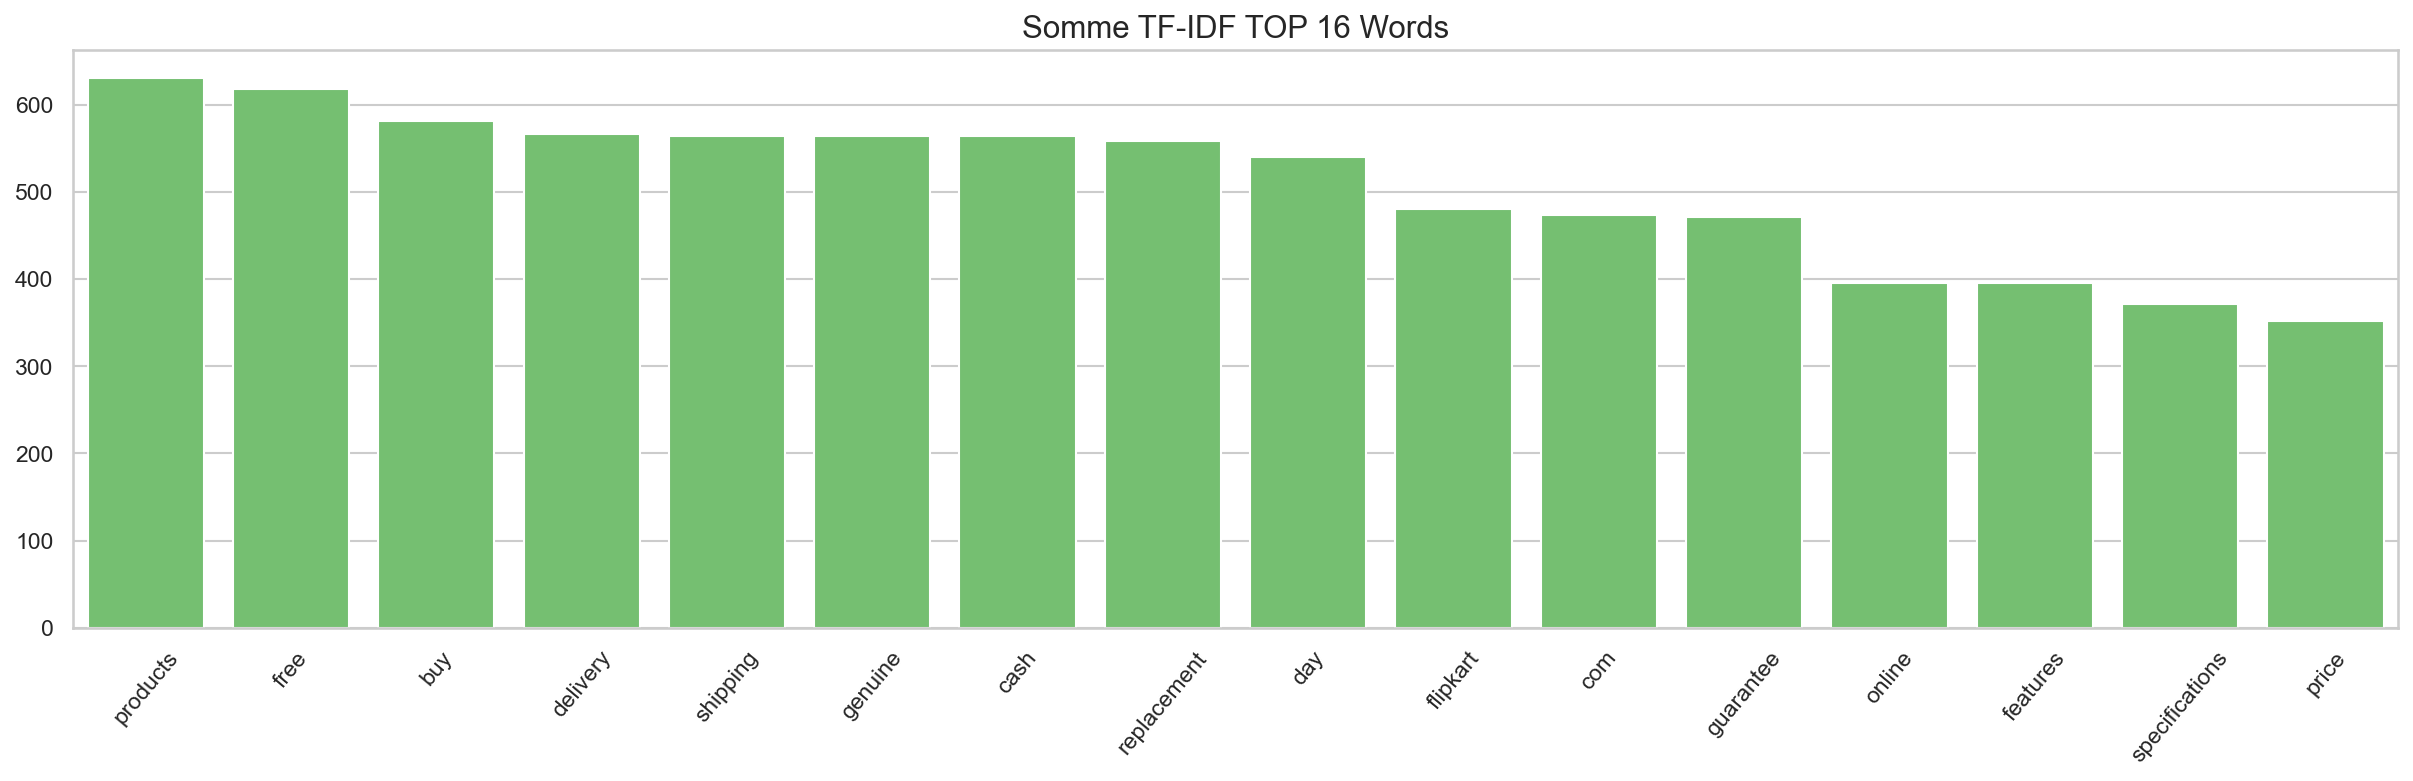

In [89]:
# Top 50 words somme count : sans lemma
plot_top_count_vectorizer(bow, train_bow, top=16, ascending=False)

Les mots courrant : 

 ['product', 'free', 'buy', 'delivery', 'shipping', 'genuine', 'cash', 'price', 'replacement', 'day', 'flipkart', 'com', 'guarantee', 'mug', 'feature', 'online']


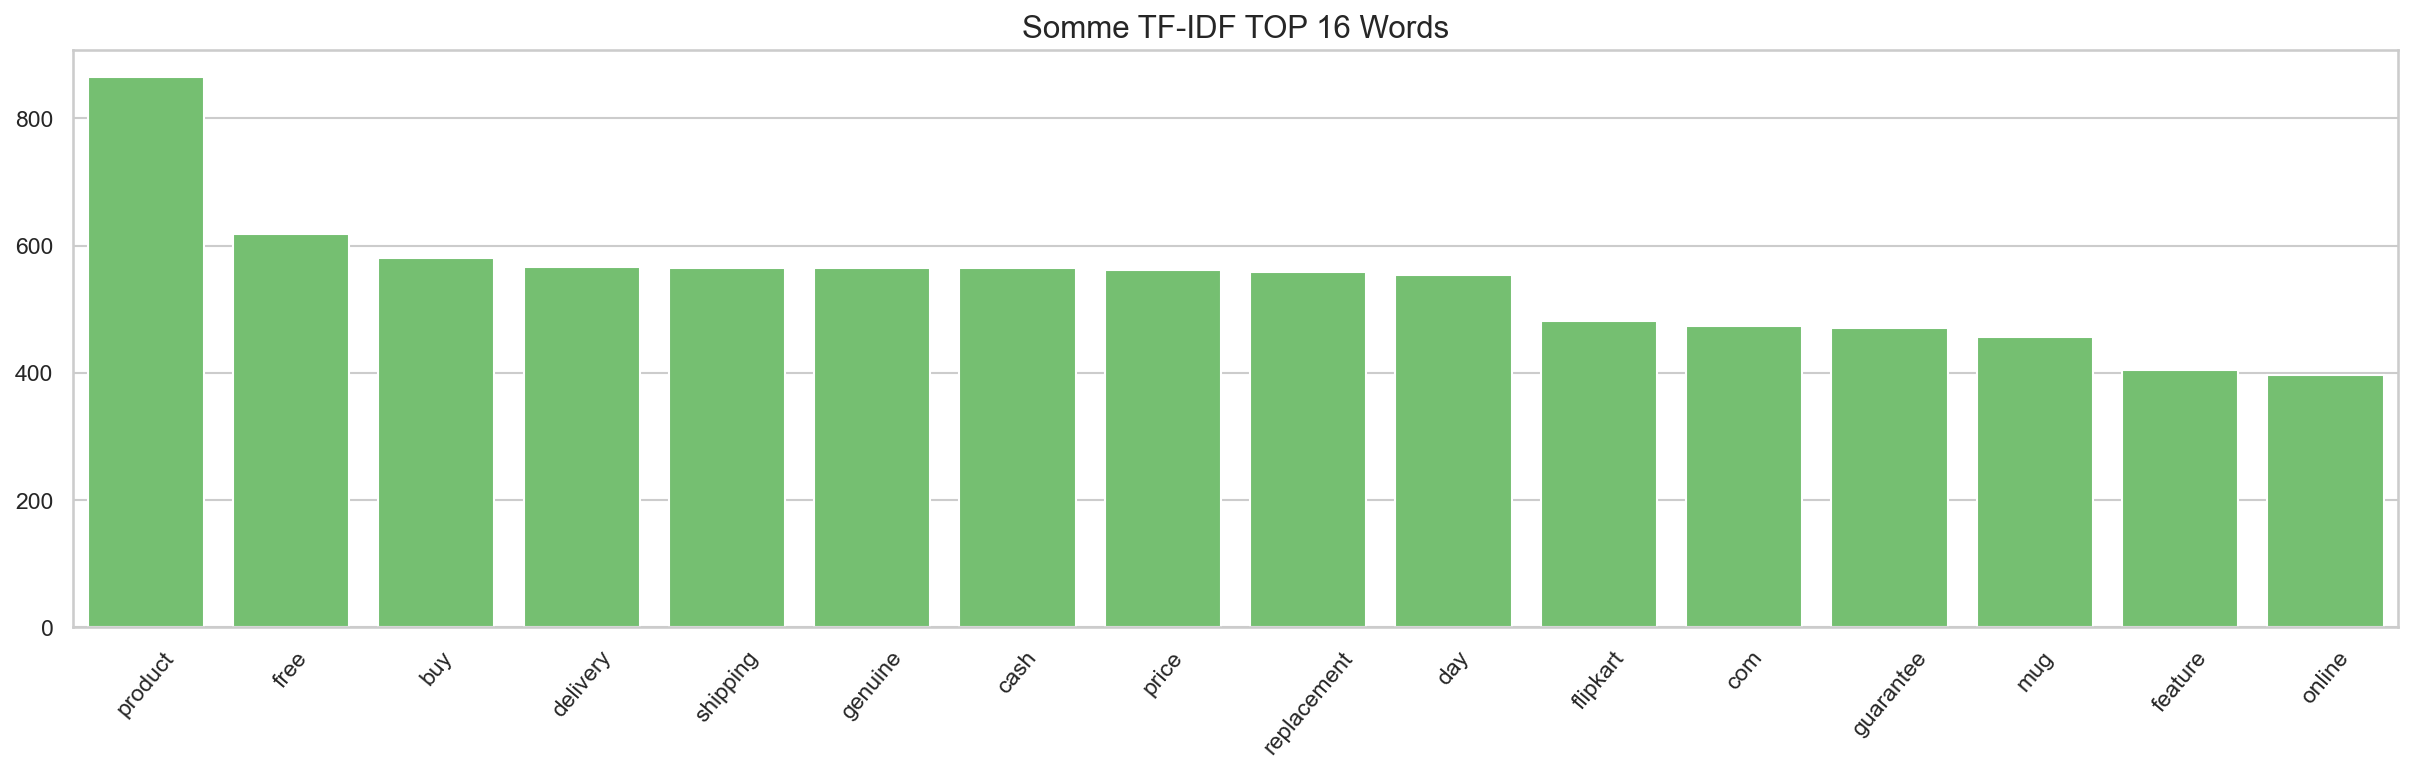

In [94]:
# Top 50 words somme count : avec  lemma
plot_top_count_vectorizer(bow_lemm, train_bow_lemmatize, top=16, ascending=False)

In [25]:
# sans lemma 

ARI, X_tsne, clusters =  calcul_tsne_ari(train_bow, pr_l = 21, lr_r=257, n_c =n_clusters, to_array=True, categories_column=categories_column)

ARI :  0.46859671444651413


In [26]:
# avec lemma
ARI, X_tsne, clusters =  calcul_tsne_ari(train_bow_lemmatize, pr_l = 53, lr_r= 10, n_c =n_clusters, to_array=True, categories_column=categories_column)

ARI :  0.5180913288106768


#### Plot clusters

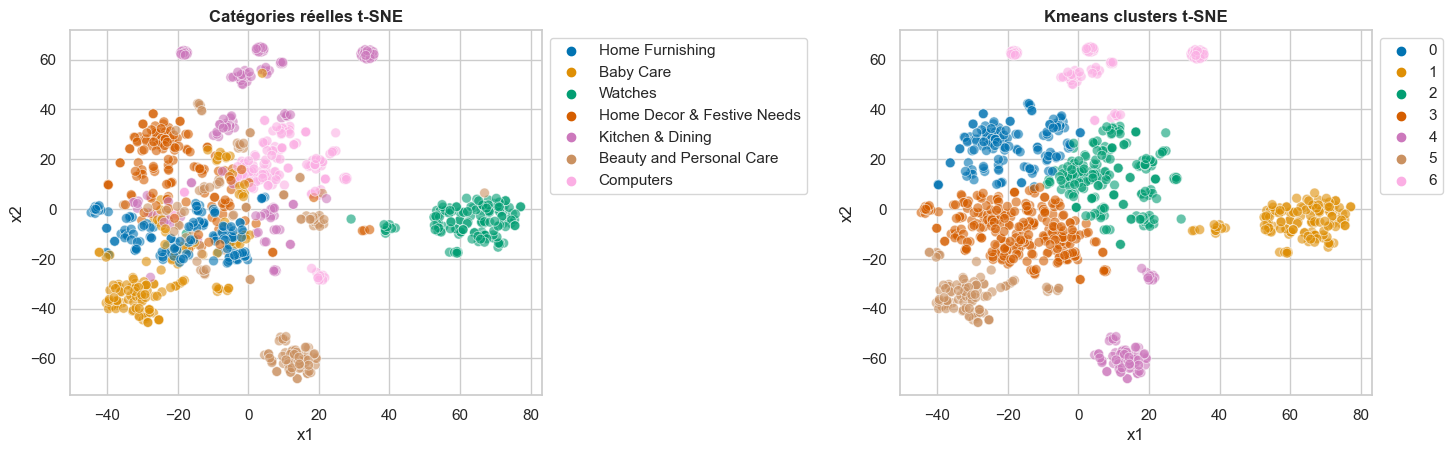

In [128]:
# sans lemma
plot_tsne_clusters(X_tsne, clusters, categories_column, plot_number=1)

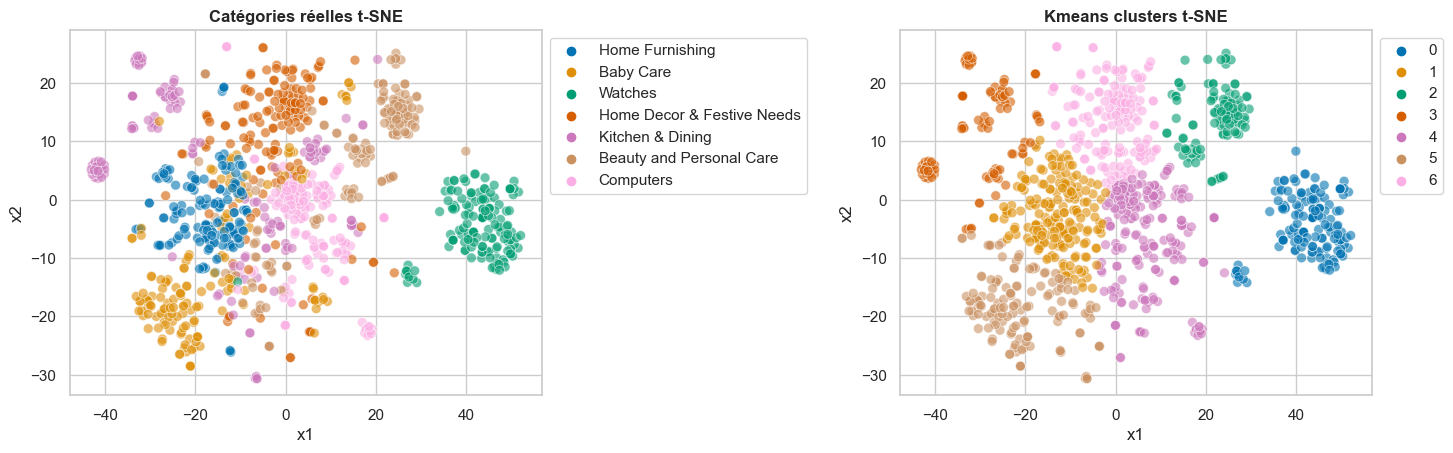

In [28]:
# avec lemma
plot_tsne_clusters(X_tsne, clusters, categories_column, plot_number=1)

####  N_grams 

In [132]:
def calcul_ari(df_train_bow,pr_l, lr_r, n_c, to_array=False, categories_column=None):
    if to_array:
        df_train_bow = df_train_bow.toarray()
        
    tsne = TSNE(n_components=2, perplexity=pr_l, learning_rate=lr_r, 
                n_iter=2000,  init='random', random_state= 0)
    
    kmeans = KMeans(n_clusters= n_c, max_iter= 300, n_init= 10,init= 'k-means++', algorithm= 'auto' )
    X_tsne = tsne.fit_transform(df_train_bow)
    kmeans.fit(X_tsne)
    ARI = adjusted_rand_score(categories_column.values, kmeans.labels_)
    return ARI

In [133]:
# sans lemmatisation
list_n_gram = [1,2,3,4]
J = [1,2,3,4]
for i in list_n_gram:
    for j in J:
        bow = CountVectorizer(max_df=0.95, min_df=1, stop_words='english', ngram_range=(i, j))
        train_bow = bow.fit_transform(data_to_vectorize['description_bow'])
        ARI =  calcul_ari(train_bow, pr_l = 21, lr_r=257, n_c =n_clusters, to_array=True, categories_column=categories_column)
        print(f"ngram_range = ({i} , {j}) - ARI : {ARI}")
    J.pop(0)
        

ngram_range = (1 , 1) - ARI : 0.47073220444278907
ngram_range = (1 , 2) - ARI : 0.3747285712222533
ngram_range = (1 , 3) - ARI : 0.36130947376493394
ngram_range = (1 , 4) - ARI : 0.31137438410851576
ngram_range = (2 , 2) - ARI : 0.26810391394358096
ngram_range = (2 , 3) - ARI : 0.27618600865626625
ngram_range = (2 , 4) - ARI : 0.2883027891651859
ngram_range = (3 , 3) - ARI : 0.2454533923110269
ngram_range = (3 , 4) - ARI : 0.2578040924297582
ngram_range = (4 , 4) - ARI : 0.23911604115153406


In [135]:
list_n_gram = [1,2,3,4]
J = [1,2,3,4]
for i in list_n_gram:
    for j in J:
        bow_lemm = CountVectorizer(max_df=0.95, min_df=1, stop_words='english', ngram_range=(i, j))
        bow_vect_lemma_ = bow_lemm.fit_transform(data_to_vectorize['description_bow_lem'])
        ARI =  calcul_ari(bow_vect_lemma_, pr_l = 53, lr_r= 10, n_c =n_clusters, to_array=True, categories_column=categories_column)
        print(f"ngram_range = ({i} , {j}) - ARI : {ARI}")
    J.pop(0)

ngram_range = (1 , 1) - ARI : 0.5168561854953873
ngram_range = (1 , 2) - ARI : 0.3674510876641736
ngram_range = (1 , 3) - ARI : 0.3678847683391656
ngram_range = (1 , 4) - ARI : 0.3270866242013741
ngram_range = (2 , 2) - ARI : 0.27982284712082167
ngram_range = (2 , 3) - ARI : 0.2549460162886181
ngram_range = (2 , 4) - ARI : 0.2664456614365646
ngram_range = (3 , 3) - ARI : 0.22050910218351347
ngram_range = (3 , 4) - ARI : 0.24484140552585046
ngram_range = (4 , 4) - ARI : 0.2255981837682347


Nous remarquons que la meilleur combinaison pour avoir un bon ARI est `ngram_rang = (1,1)`

### Vectorizer TF-IDF 

`CountVectorizer` :Convertir une collection de documents bruts en une matrice de features TF-IDF. Équivalent à CountVectorizer suivi de TfidfTransformer. [Voir guide d'utilisateur](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

In [19]:
# vectorisation sans lemmatisation 
tfidf = TfidfVectorizer(max_df=0.95, min_df=1, stop_words='english')
train_vect = tfidf.fit_transform(data_to_vectorize['description_bow'])

In [21]:
train_vect.shape

(1050, 4662)

In [20]:
# vectorisation avec lemmatisation
tfidf_lemm = TfidfVectorizer(max_df=0.95, min_df=1, stop_words='english')
train_vect_lemmatize = tfidf_lemm.fit_transform(data_to_vectorize['description_bow_lem'])

In [22]:
train_vect_lemmatize.shape

(1050, 4250)

**save des vecteurs**

In [97]:
tf_idf_to_save = train_vect.toarray()
with open('./data/features_extracted/TF_IDF_Features.npy', 'wb') as f:
    np.save(f, tf_idf_to_save, allow_pickle=True)

In [98]:
tf_idf_to_save = train_vect_lemmatize.toarray()
with open('./data/features_extracted/TF_IDF_lemm_Features.npy', 'wb') as f:
    np.save(f, tf_idf_to_save, allow_pickle=True)

#### Fine tuning TSNE 

In [138]:
# Fine tune des deux hyper param de la t-SNE : Perplex et LR :
# sans lemmatisation
fine_tune_tsne_parametre(PERPLEX, LR, cls=kmeans, train = train_vect, to_array=True)

learning_rate  perplexity  TIME_      ARI_
9            1000          21    9.0  0.548774
5              10          21    9.0  0.526480
6             257          21    8.0  0.515050
7             505          21    9.0  0.513274
8             752          21    8.0  0.509176
15             10          53   12.0  0.476220
13            752          37   10.0  0.457151
0              10           5    7.0  0.455776
18            752          53   12.0  0.452862
14           1000          37   11.0  0.447861
11            257          37   11.0  0.447132
22            505          70   15.0  0.444624
19           1000          53   12.0  0.433155
21            257          70   15.0  0.428928
12            505          37   11.0  0.425797
16            257          53   12.0  0.407170
4            1000           5    7.0  0.392473
10             10          37   10.0  0.391137
23            752          70   14.0  0.388860
17            505          53   12.0  0.386427
3             752           5    8.0  0.382914
24           1000          70   14.0  0.380944
20             10          70   14.0  0.378008
2             505           5    7.0  0.328147
1             257           5    8.0  0.322069

In [139]:
# avec lemmatisation
fine_tune_tsne_parametre(PERPLEX, LR, cls=kmeans, train = train_vect_lemmatize, to_array=True)

learning_rate  perplexity  TIME_      ARI_
6             257          21    9.0  0.566516
5              10          21    8.0  0.552270
9            1000          21    9.0  0.533886
8             752          21    9.0  0.521707
17            505          53   12.0  0.509902
7             505          21    9.0  0.496817
0              10           5    7.0  0.489680
19           1000          53   13.0  0.477021
14           1000          37   11.0  0.456735
18            752          53   13.0  0.445793
21            257          70   14.0  0.434754
10             10          37   11.0  0.430724
15             10          53   12.0  0.425959
16            257          53   12.0  0.425480
1             257           5    7.0  0.425477
11            257          37   11.0  0.423891
22            505          70   15.0  0.415447
12            505          37   11.0  0.414500
13            752          37   11.0  0.406319
3             752           5    7.0  0.401872
23            752          70   15.0  0.398910
24           1000          70   15.0  0.398380
4            1000           5    8.0  0.387884
2             505           5    8.0  0.386181
20             10          70   14.0  0.378412

Les mots courrant : 

 ['com', 'flipkart', 'genuine', 'shipping', 'cash', 'delivery', 'products', 'buy', 'free', 'day', 'replacement', 'guarantee', 'watch']


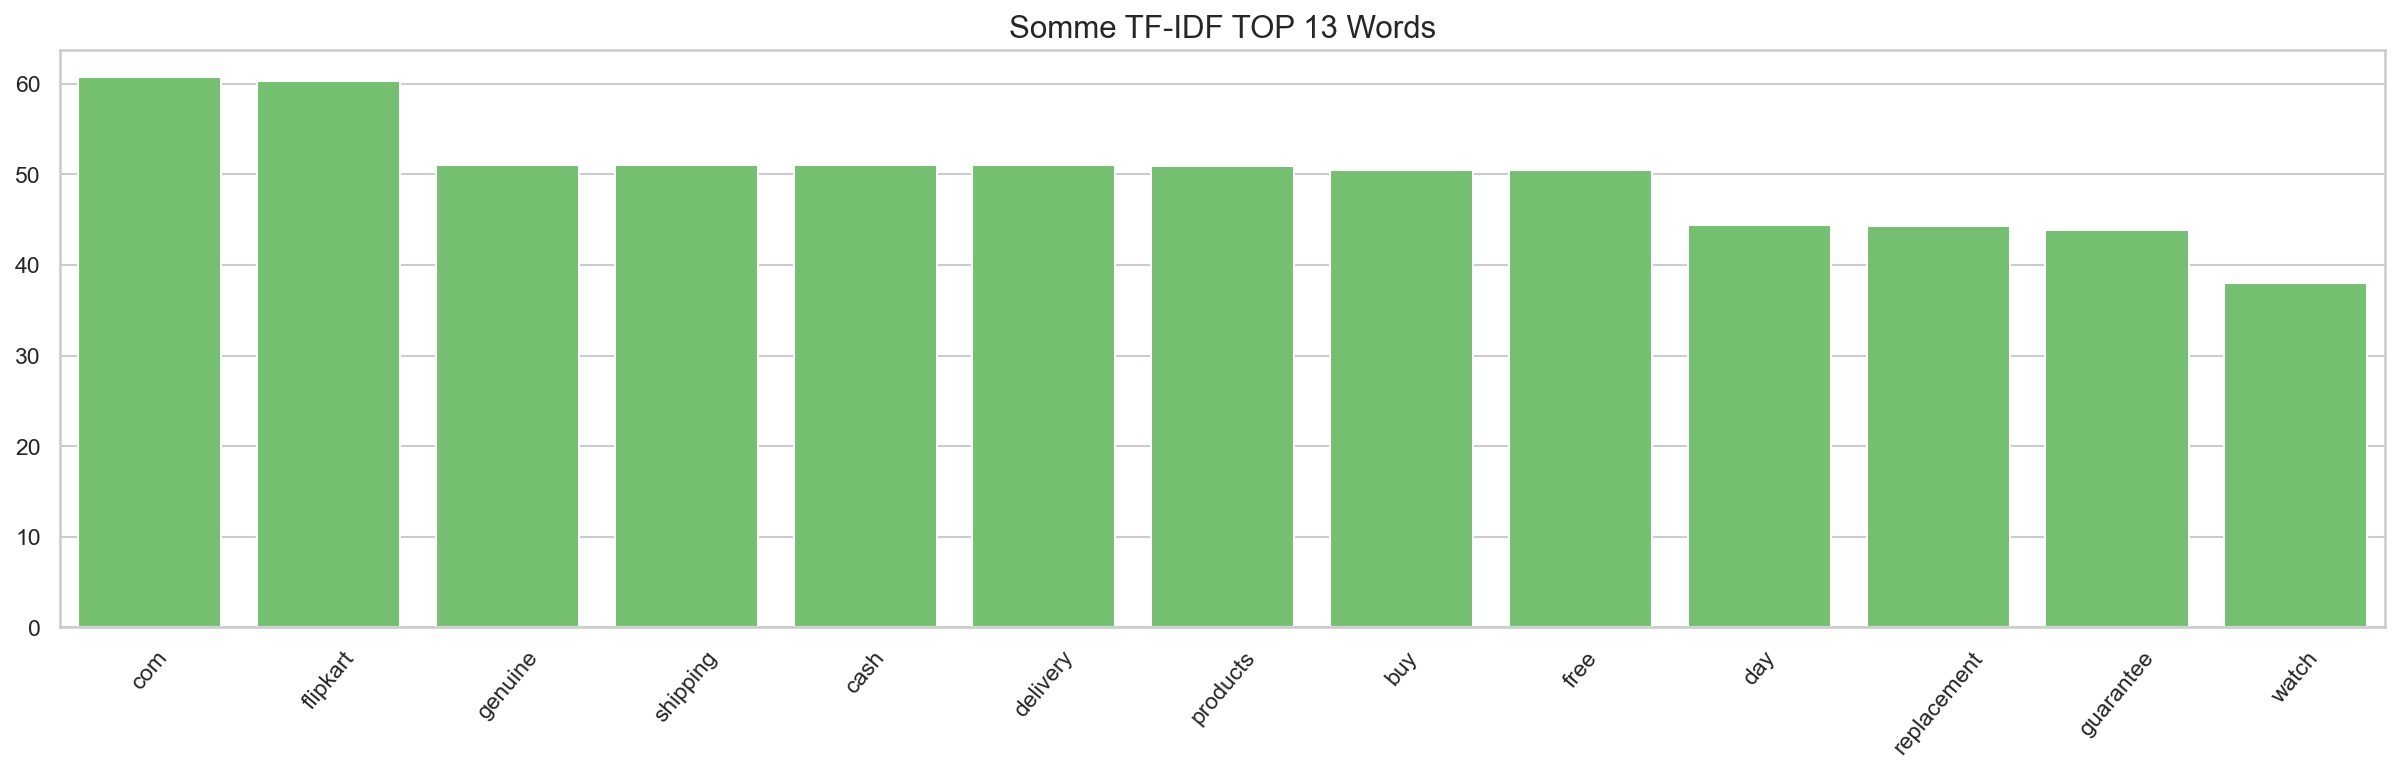

In [99]:
# Top 50 words somme count : sans lemmatisation 
plot_top_count_vectorizer(tfidf, train_vect,top=13, ascending=False)

Les mots courrant : 

 ['com', 'flipkart', 'genuine', 'cash', 'shipping', 'delivery', 'product', 'buy', 'free', 'replacement', 'day', 'guarantee', 'watch']


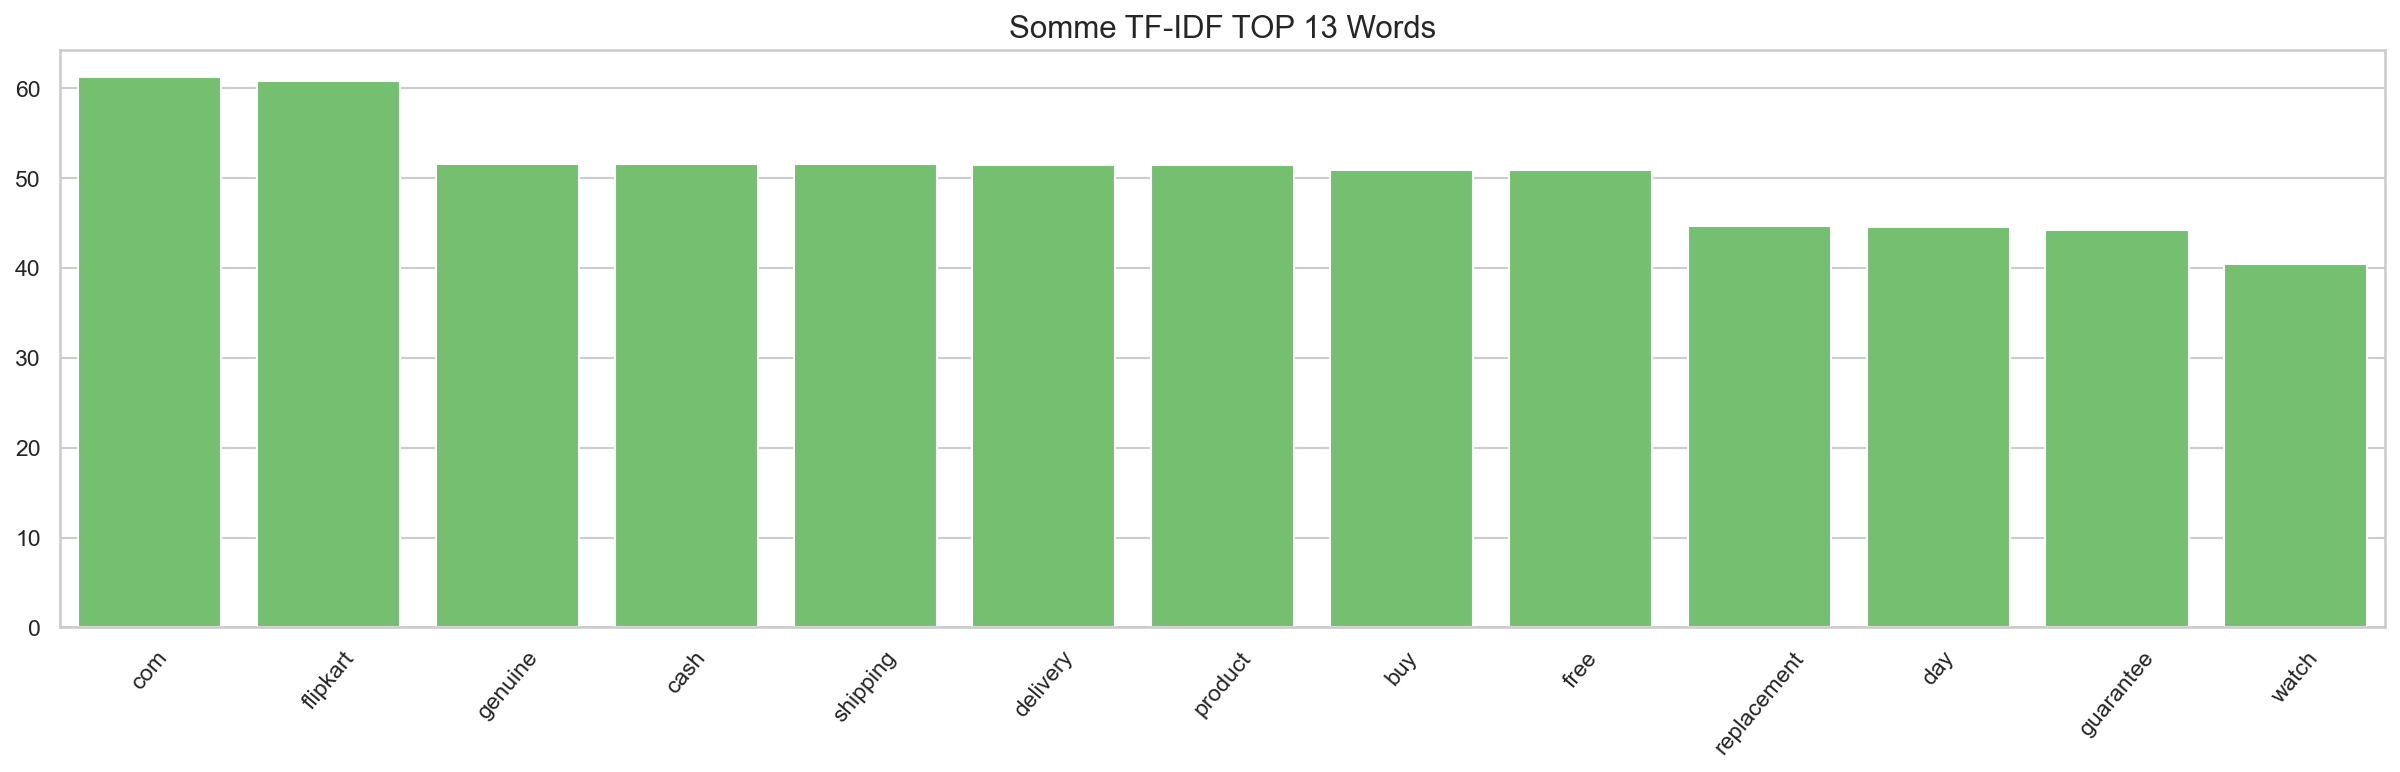

In [101]:
# Top 50 words somme count : avec lemmatisation 
plot_top_count_vectorizer(tfidf_lemm, train_vect_lemmatize,top=13, ascending=False)

In [140]:
# sans lemma 

ARI, X_tsne, clusters =  calcul_tsne_ari(train_vect, pr_l = 21, lr_r=752, n_c =n_clusters, to_array=True, categories_column=categories_column)

ARI :  0.509176294557292


In [29]:
# avec lemma
ARI, X_tsne, clusters =  calcul_tsne_ari(train_vect_lemmatize, pr_l = 21, lr_r=10, n_c =n_clusters, to_array=True, categories_column=categories_column)

ARI :  0.552269950473011


#### Plot clusters

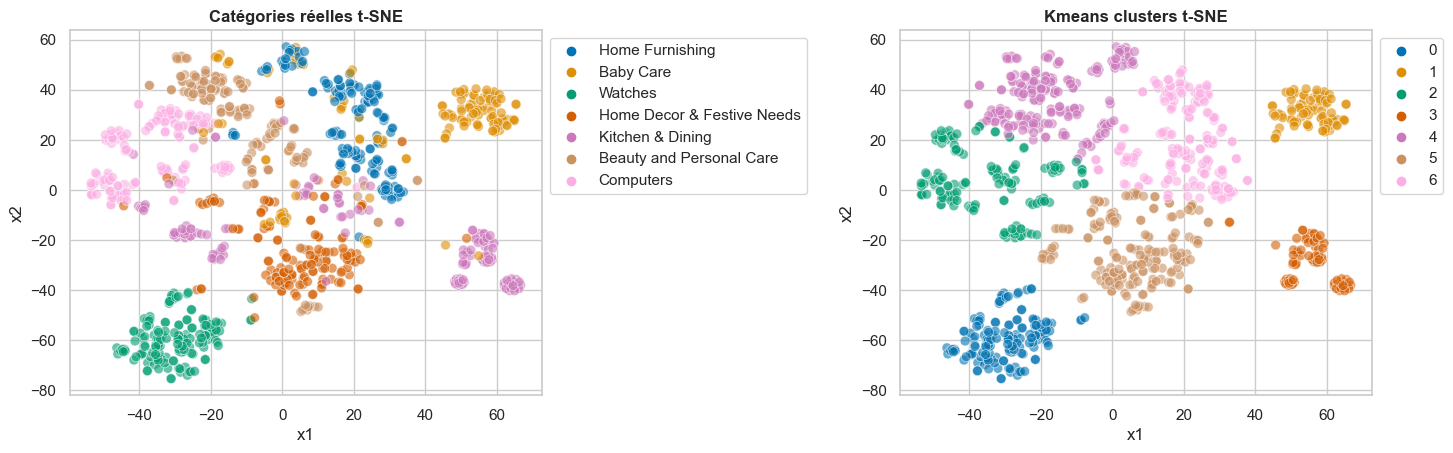

In [141]:
# sans lemma
plot_tsne_clusters(X_tsne, clusters, categories_column)

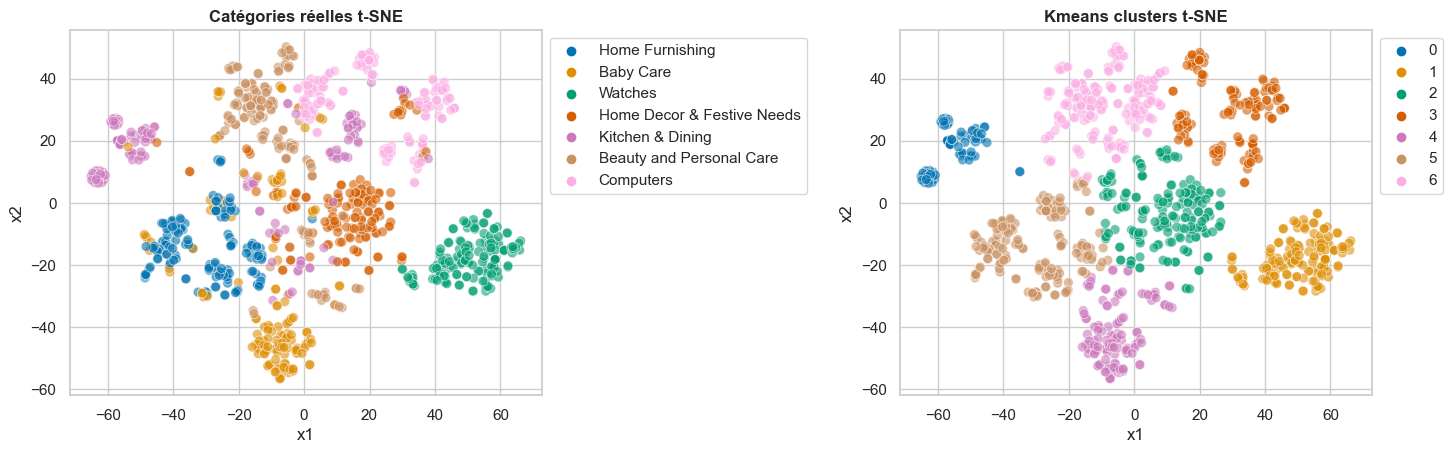

In [30]:
# avec lemma
plot_tsne_clusters(X_tsne, clusters, categories_column, plot_number=2)

####  N_grams 

In [116]:
# sans lemmatisation 
list_n_gram = [1,2,3,4]
J = [1,2,3,4]
for i in list_n_gram:
    for j in J:
        tfidf_ = TfidfVectorizer(max_df=0.95, min_df=1, stop_words='english', ngram_range=(i, j))
        tfidf_vect_ = tfidf_.fit_transform(data_to_vectorize['description_bow'])
        ARI =  calcul_ari(tfidf_vect_, pr_l = 21, lr_r=752, n_c =n_clusters, to_array=True, categories_column=categories_column)
        print(f"ngram_range = ({i} , {j}) - ARI : {ARI}")
    J.pop(0)
        

ngram_range = (1 , 1) - ARI : 0.5397952617596883
ngram_range = (1 , 2) - ARI : 0.5441733586166916
ngram_range = (1 , 3) - ARI : 0.5156778072700193
ngram_range = (1 , 4) - ARI : 0.40093479649433317
ngram_range = (2 , 2) - ARI : 0.3507481210570541
ngram_range = (2 , 3) - ARI : 0.34799426486252466
ngram_range = (2 , 4) - ARI : 0.3773287909828458
ngram_range = (3 , 3) - ARI : 0.3216652094157032
ngram_range = (3 , 4) - ARI : 0.32792362026800875
ngram_range = (4 , 4) - ARI : 0.2935162230624395


In [117]:
# avec  lemmatisation 
list_n_gram = [1,2,3,4]
J = [1,2,3,4]
for i in list_n_gram:
    for j in J:
        tfidf_lemm_ = TfidfVectorizer(max_df=0.95, min_df=1, stop_words='english', ngram_range=(i, j))
        tfidf_vect__lemm_ = tfidf_lemm_.fit_transform(data_to_vectorize['description_bow_lem'])
        ARI =  calcul_ari(tfidf_vect__lemm_, pr_l = 21, lr_r=10, n_c =n_clusters, to_array=True, categories_column=categories_column)
        print(f"ngram_range = ({i} , {j}) - ARI : {ARI}")
    J.pop(0)

ngram_range = (1 , 1) - ARI : 0.5667023862668361
ngram_range = (1 , 2) - ARI : 0.4574368051152961
ngram_range = (1 , 3) - ARI : 0.4759679646609736
ngram_range = (1 , 4) - ARI : 0.4208009043598614
ngram_range = (2 , 2) - ARI : 0.40783758933598485
ngram_range = (2 , 3) - ARI : 0.3911220042060053
ngram_range = (2 , 4) - ARI : 0.3766303281983644
ngram_range = (3 , 3) - ARI : 0.36339897725004433
ngram_range = (3 , 4) - ARI : 0.3471103087795408
ngram_range = (4 , 4) - ARI : 0.29831832419712007


## Word Embeddings Methods

In [72]:
import tensorflow as tf

In [33]:
import tensorflow_text

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
import tensorflow.keras

In [37]:
from tensorflow.keras.layers import *

In [38]:
from tensorflow.keras.models import Model

In [45]:
import tensorflow_hub as hub
from tensorflow.keras import backend as K
from tensorflow.keras import metrics as kmetrics
import transformers
from transformers import TFAutoModel
from transformers import AutoTokenizer


### Word2Vec

In [50]:
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec


In [51]:
print("gensim version:", gensim.__version__)

gensim version: 4.3.0


In [18]:
w2v_window=5 # Nombre de mot dans le contexte
w2v_size=300
w2v_min_count=1 # Nombre de mot min par phrase pour être utilisée dans l'entrainement
w2v_epochs=100
# workers = CPU nombre de coeurs à utiliser 
maxlen = 356 
sentences = data_to_vectorize['description_bow'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [19]:
print(sentences)

[['key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhances', 'look', 'interiors', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabric', 'features', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'makes', 'room', 'environment', 'romantic', 'loving', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparance', 'give', 'home', 'bright', 'modernistic', 'appeal', 'designs', 'surreal', 'attention', 'sure', 'steal', 'hearts', 'contemporary', 'eyelet', 'valance', 'curtains', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'rays', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moments', 'joyous', 'beauty', 'given', 'soothing', 'prints', 'bring', 'home', 'elegant', 'curtain', 'softly', 'f

In [20]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=4 )
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4761
Word2Vec trained


In [21]:
model_vectors

In [22]:
len(w2v_words)

4761

In [23]:
w2v_model.wv.most_similar('boy', topn=10)

[('girl', 0.7105582356452942),
 ('striped', 0.7102263569831848),
 ('klub', 0.6758000254631042),
 ('casual', 0.5990917682647705),
 ('woven', 0.5899918079376221),
 ('sleepsuit', 0.5825446248054504),
 ('shirt', 0.5734282732009888),
 ('jumpsuit', 0.5648801326751709),
 ('melange', 0.5562637448310852),
 ('neck', 0.549112856388092)]

In [24]:
w2v_model.wv.most_similar('men', topn=10)

[('women', 0.7666604518890381),
 ('analog', 0.7140369415283203),
 ('sonata', 0.7058808207511902),
 ('decker', 0.6883436441421509),
 ('watch', 0.6842551231384277),
 ('hmtwhq', 0.6789326071739197),
 ('maxima', 0.6718475222587585),
 ('lcs', 0.6533663868904114),
 ('boys', 0.6469385623931885),
 ('pcc', 0.6456745266914368)]

In [25]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4762


In [26]:
x_sentences

array([[  41,   14,  720, ...,    0,    0,    0],
       [  15, 1852,   25, ...,    0,    0,    0],
       [  41,   14, 1133, ...,    0,    0,    0],
       ...,
       [   3, 1847,  698, ...,    0,    0,    0],
       [   3,  536,  349, ...,    0,    0,    0],
       [   3, 1847,  377, ...,    0,    0,    0]])

In [27]:
tokenizer.word_index

{'products': 1,
 'free': 2,
 'buy': 3,
 'delivery': 4,
 'genuine': 5,
 'shipping': 6,
 'cash': 7,
 'replacement': 8,
 'day': 9,
 'flipkart': 10,
 'com': 11,
 'guarantee': 12,
 'online': 13,
 'features': 14,
 'specifications': 15,
 'price': 16,
 'watch': 17,
 'color': 18,
 'mug': 19,
 'baby': 20,
 'pack': 21,
 'material': 22,
 'set': 23,
 'type': 24,
 'cotton': 25,
 'box': 26,
 'general': 27,
 'package': 28,
 'analog': 29,
 'sales': 30,
 'number': 31,
 'warranty': 32,
 'quality': 33,
 'details': 34,
 'product': 35,
 'brand': 36,
 'best': 37,
 'design': 38,
 'model': 39,
 'ceramic': 40,
 'key': 41,
 'laptop': 42,
 'fabric': 43,
 'prices': 44,
 'showpiece': 45,
 'made': 46,
 'great': 47,
 'perfect': 48,
 'india': 49,
 'men': 50,
 'usb': 51,
 'size': 52,
 'inch': 53,
 'dimensions': 54,
 'ideal': 55,
 'girl': 56,
 'home': 57,
 'skin': 58,
 'multicolor': 59,
 'contents': 60,
 'combo': 61,
 'water': 62,
 'gift': 63,
 'women': 64,
 'printed': 65,
 'discounts': 66,
 'mugs': 67,
 'width': 68,
 '

In [28]:
x_sentences

array([[  41,   14,  720, ...,    0,    0,    0],
       [  15, 1852,   25, ...,    0,    0,    0],
       [  41,   14, 1133, ...,    0,    0,    0],
       ...,
       [   3, 1847,  698, ...,    0,    0,    0],
       [   3,  536,  349, ...,    0,    0,    0],
       [   3, 1847,  377, ...,    0,    0,    0]])

In [29]:
# Exemple pour le mot men 
model_vectors['men']

array([-1.07600605e+00,  1.37386191e+00,  1.28540203e-01,  8.87356400e-01,
        1.31964564e+00,  6.04884386e-01, -7.68533826e-01,  9.81315494e-01,
       -4.75560397e-01,  1.49463952e+00,  8.86330783e-01, -8.56135130e-01,
        1.94173443e+00,  5.27854204e-01, -6.21797331e-02, -9.29256558e-01,
       -8.04325879e-01, -6.21899188e-01, -1.88333601e-01,  1.32268345e+00,
        1.20819733e-01, -2.22446886e-03,  9.73212659e-01,  7.21672773e-01,
        2.30734301e+00, -1.70789808e-01, -3.45410407e-01,  3.02642226e-01,
       -4.80692498e-02, -9.97931585e-02,  8.42684746e-01, -2.08557892e+00,
        1.82751679e+00, -1.92289615e+00,  1.85716367e+00, -2.72025824e-01,
        7.01949000e-01, -7.15588406e-02,  1.65624991e-01,  9.73323941e-01,
        4.80592638e-01, -9.93839383e-01, -3.35203111e-01,  1.64570236e+00,
        3.45327616e-01,  2.92144597e-01, -1.23357570e+00, -3.28160644e-01,
       -4.89241421e-01,  1.06546175e+00,  8.23138297e-01, -7.91722119e-01,
       -1.03359461e+00, -

In [30]:
# Les mots de notre vocabulaire
w2v_words

['products',
 'free',
 'buy',
 'delivery',
 'cash',
 'shipping',
 'genuine',
 'replacement',
 'day',
 'flipkart',
 'com',
 'guarantee',
 'online',
 'features',
 'specifications',
 'price',
 'watch',
 'color',
 'mug',
 'baby',
 'pack',
 'material',
 'set',
 'type',
 'cotton',
 'box',
 'general',
 'package',
 'analog',
 'sales',
 'number',
 'warranty',
 'quality',
 'details',
 'product',
 'brand',
 'best',
 'design',
 'model',
 'ceramic',
 'key',
 'laptop',
 'fabric',
 'prices',
 'showpiece',
 'great',
 'made',
 'perfect',
 'india',
 'men',
 'usb',
 'size',
 'inch',
 'ideal',
 'girl',
 'dimensions',
 'skin',
 'home',
 'multicolor',
 'contents',
 'combo',
 'water',
 'gift',
 'women',
 'printed',
 'discounts',
 'mugs',
 'black',
 'width',
 'wash',
 'also',
 'print',
 'care',
 'power',
 'battery',
 'blue',
 'cover',
 'light',
 'adapter',
 'use',
 'coffee',
 'yes',
 'pattern',
 'height',
 'high',
 'style',
 'length',
 'one',
 'easy',
 'dress',
 'name',
 'weight',
 'round',
 'designed',
 'bod

In [31]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4762, 300)


In [32]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.2834326 ,  1.2719177 ,  1.06224668, ..., -0.83484393,
        -1.38074791, -0.9573133 ],
       [-2.0253787 ,  1.6560601 , -0.40677848, ..., -0.63697666,
        -1.288252  , -0.4286229 ],
       ...,
       [ 0.00459971, -0.10626777, -0.05431993, ...,  0.03537478,
        -0.07548049,  0.02965364],
       [-0.08718082, -0.18532321, -0.09739875, ...,  0.10446076,
         0.19430828,  0.17962928],
       [ 0.0362    , -0.05413987, -0.03855762, ...,  0.07292058,
        -0.08156822, -0.00623351]])

In [33]:
embedding_matrix.shape

(4762, 300)

In [34]:
word_index.items()

dict_items([('products', 1), ('free', 2), ('buy', 3), ('delivery', 4), ('genuine', 5), ('shipping', 6), ('cash', 7), ('replacement', 8), ('day', 9), ('flipkart', 10), ('com', 11), ('guarantee', 12), ('online', 13), ('features', 14), ('specifications', 15), ('price', 16), ('watch', 17), ('color', 18), ('mug', 19), ('baby', 20), ('pack', 21), ('material', 22), ('set', 23), ('type', 24), ('cotton', 25), ('box', 26), ('general', 27), ('package', 28), ('analog', 29), ('sales', 30), ('number', 31), ('warranty', 32), ('quality', 33), ('details', 34), ('product', 35), ('brand', 36), ('best', 37), ('design', 38), ('model', 39), ('ceramic', 40), ('key', 41), ('laptop', 42), ('fabric', 43), ('prices', 44), ('showpiece', 45), ('made', 46), ('great', 47), ('perfect', 48), ('india', 49), ('men', 50), ('usb', 51), ('size', 52), ('inch', 53), ('dimensions', 54), ('ideal', 55), ('girl', 56), ('home', 57), ('skin', 58), ('multicolor', 59), ('contents', 60), ('combo', 61), ('water', 62), ('gift', 63), ('

In [42]:
# Création du modèle

# input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 356)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 356, 300)          1428600   
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 1,428,600
Trainable params: 1,428,600
Non-trainable params: 0
_________________________________________________________________


In [43]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 5ms/step


(1050, 300)

In [44]:
embeddings

array([[ 0.11126272,  0.18091105,  0.05511863, ..., -0.0595869 ,
         0.06198252, -0.06285566],
       [ 0.06603198,  0.08831099, -0.02402442, ..., -0.13348538,
         0.10370225, -0.02655601],
       [ 0.07354402,  0.14706671,  0.0048151 , ..., -0.21505699,
         0.11197619, -0.06912929],
       ...,
       [-0.04166941, -0.00235922, -0.00099614, ...,  0.01686903,
        -0.06161594,  0.0134562 ],
       [-0.04427681,  0.0166835 ,  0.00595198, ...,  0.01115728,
        -0.05502446,  0.01291766],
       [-0.04413691,  0.01171511,  0.00472266, ...,  0.00943229,
        -0.05150611,  0.01419642]], dtype=float32)

#### Fine tuning TSNE 

In [45]:
fine_tune_tsne_parametre(PERPLEX, LR, cls=kmeans, train = embeddings, to_array=False)

learning_rate  perplexity  TIME_      ARI_
17            505          53   13.0  0.376351
12            505          37   12.0  0.355565
19           1000          53   14.0  0.354823
5              10          21    9.0  0.353736
16            257          53   12.0  0.351844
10             10          37   11.0  0.347073
11            257          37   12.0  0.343801
15             10          53   13.0  0.342349
23            752          70   15.0  0.341437
18            752          53   13.0  0.332295
9            1000          21    9.0  0.329686
24           1000          70   11.0  0.329001
6             257          21    9.0  0.327792
7             505          21    9.0  0.325990
13            752          37   12.0  0.319128
14           1000          37   11.0  0.314441
21            257          70   16.0  0.314131
20             10          70   16.0  0.309730
22            505          70   15.0  0.303445
0              10           5    8.0  0.303206
8             752          21    9.0  0.301891
4            1000           5    9.0  0.236811
3             752           5    9.0  0.220094
2             505           5   13.0  0.194906
1             257           5    9.0  0.156218

In [47]:
ARI, X_tsne, clusters =  calcul_tsne_ari(embeddings, pr_l = 53, lr_r=505, n_c=n_clusters, to_array=False, categories_column=categories_column)

ARI :  0.3763509726147085


#### Plot clusters

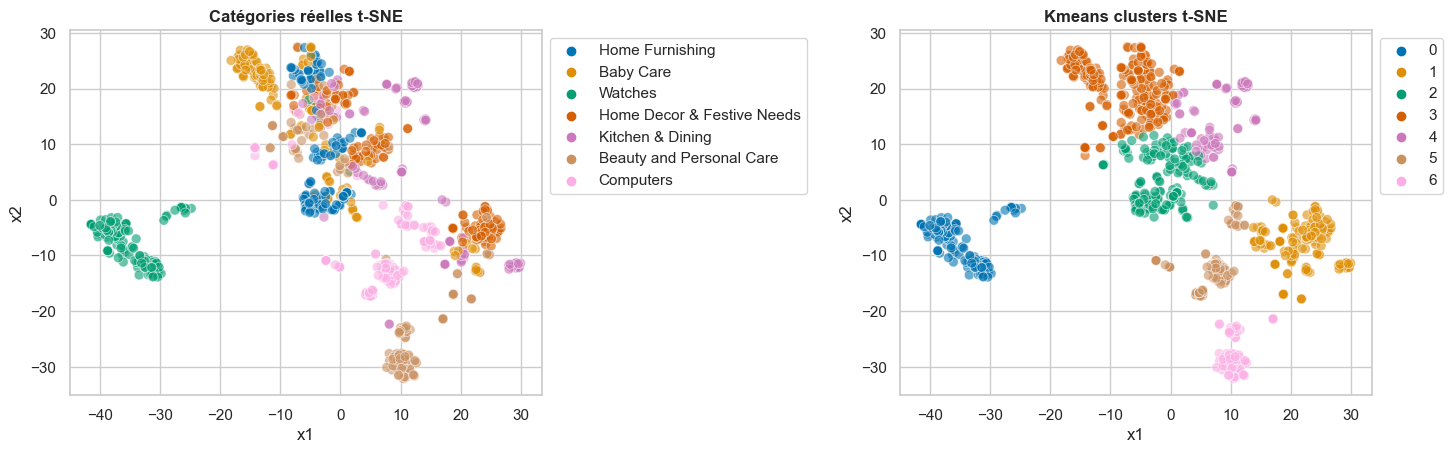

In [48]:
plot_tsne_clusters(X_tsne, clusters, categories_column)

### BERT

### Implémentation

In [48]:
import tensorflow.keras

In [49]:
print(tensorflow.__version__)

2.10.1


In [37]:
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [48]:
# Preprocessing 
bert_preprocess_model = hub.KerasLayer(preprocess_url)

In [55]:
# Model 
bert_model = hub.KerasLayer(encoder_url, trainable=True)

In [53]:
sentence = text_data['description'][1000]
sentence = [sentence]
sentence

['Key Features of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container Airtight Pack of 6,Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) Price: Rs. 2,145 Flexible Silicone Seal Ensures Precision Lid Fitting.Large Locking Hinges For Easy Open And Closing Movement.Fridge And Freezer Safe,Specifications of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) General Brand Lock&Lock Model Number HPL816X3,HPL806X2,HPL836 Disposable No Model Name Kitchen Material Polypropylene Airtight Yes Capacity 5.5 L Container Type Multi-purpose Storage Container Color Clear In the box Sales Package 6 CONTAINER Pack of 6 Warranty Covered in Warranty Manufacturing Defects Warranty Summary 1 year warranty on manufacturing defects. Warranty Service Type Customer Care Not Covered in Warranty Accidental Damages']

In [59]:
# Preprocessing avec le preprocesseur bert_en_uncased_preprocess 
preprocessed_tensence = bert_preprocess_model(sentence)
preprocessed_tensence

{'input_word_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[  101,  3145,  2838,  1997,  5843,  1004,  5843,  3829,  1011,
          1019,  1012,  1019,  1048, 26572, 21572,  7685, 11474,  4800,
          1011,  3800,  5527, 11661,  2250, 26143,  5308,  1997,  1020,
          1010,  5843,  1004,  5843,  3829,  1011,  1019,  1012,  1019,
          1048, 26572, 21572,  7685, 11474,  4800,  1011,  3800,  5527,
         11661,  1006,  5308,  1997,  1020,  1010,  3154,  1007,  3976,
          1024, 12667,  1012,  1016,  1010, 13741, 12379, 13773,  2063,
          7744, 21312, 11718, 11876, 11414,  1012,  2312, 14889, 25484,
          2005,  3733,  2330,  1998,  5494,  2929,  1012, 16716,  1998,
         13184,  2099,  3647,  1010, 15480,  1997,  5843,  1004,  5843,
          3829,  1011,  1019,  1012,  1019,  1048, 26572, 21572,  7685,
         11474,  4800,  1011,  3800,  5527, 11661,  1006,  5308,  1997,
          1020,  1010,  3154,  1007,  2236,  4435,  5843,  1004,  584

In [47]:
from tqdm import tqdm

# Fonction de préparation des documents
def bert_inp_fct(documents, bert_tokenizer, max_length):
    """Function that returns the inputs for BERT model"""
    input_ids = []
    token_type_ids = []
    attention_mask = []

    for doc in documents:
        bert_inp = bert_tokenizer.encode_plus(doc,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.asarray(attention_mask)
    
    return input_ids, token_type_ids, attention_mask
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, documents, max_length, batch_size, mode='HF'):
    
    # Calcul du nombre de batches
    quotient = len(documents)//batch_size
    remainder = len(documents)%batch_size
    if remainder == 0:
        n_batches = quotient
    else:
        n_batches = quotient + 1
    
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    
    time1 = time.time()
    for step in tqdm(range(n_batches)):
        idx = step*batch_size
        if step < quotient:
            b_size = batch_size
        else:
            b_size = remainder

        input_ids, token_type_ids, attention_mask = bert_inp_fct(documents[idx:idx+b_size], 
                                                                 bert_tokenizer, max_length)
        
        if mode == 'HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=b_size,
                                    verbose=0)
            last_hidden_states = outputs.last_hidden_state

        if mode == 'TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step == 0 :
            last_hidden_states_tot = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot, last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = time.time()
    print("temps de traitement : ", np.round(time2-time1, 0), 's')

    return features_bert, last_hidden_states_tot

#### HuggingFace

In [69]:
# Bert HuggingFace
max_length = 356
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
documents = data_to_vectorize['description_bow'].to_list()

# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, documents, 
                                                         max_length, batch_size, mode='HF')

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 105/105 [01:43<00:00,  1.02it/s]

temps de traitement :  103.0 s


In [70]:
features_bert.shape

(1050, 768)

In [73]:
PERPLEX = np.linspace(5, 70, 5, dtype=int)
LR = np.linspace(10, 1000, 5, dtype=int)
l_cat = list(set(data_to_vectorize['product_category_1']))
n_clusters = len(l_cat)
kmeans = KMeans(n_clusters= n_clusters, max_iter= 300, n_init= 10,init= 'k-means++', algorithm= 'auto' )

fine_tune_tsne_parametre(PERPLEX, LR, cls=kmeans, train = features_bert, to_array=False)

learning_rate  perplexity  TIME_      ARI_
7             505          21    7.0  0.352594
6             257          21    7.0  0.341945
8             752          21    7.0  0.340139
14           1000          37    9.0  0.339992
11            257          37    8.0  0.339927
21            257          70   12.0  0.338746
10             10          37    8.0  0.338622
20             10          70   11.0  0.338272
19           1000          53   10.0  0.336398
9            1000          21    7.0  0.333732
5              10          21    6.0  0.332711
17            505          53   10.0  0.332377
12            505          37    9.0  0.331448
18            752          53    9.0  0.331299
22            505          70   12.0  0.329494
23            752          70   12.0  0.326057
16            257          53   10.0  0.321893
13            752          37    8.0  0.321072
15             10          53   10.0  0.309549
24           1000          70   11.0  0.302548
3             752           5    6.0  0.300540
2             505           5    5.0  0.296440
4            1000           5    6.0  0.292520
1             257           5    5.0  0.250590
0              10           5    6.0  0.230893

In [76]:
categories_column = data_to_vectorize['product_cataegory_1']
n_clusters = len(categories_column.unique())
ARI, X_tsne, clusters =  calcul_tsne_ari(features_bert, pr_l = 21, lr_r=257, n_c=n_clusters, to_array=False, categories_column=categories_column)

ARI :  0.33677396728673076


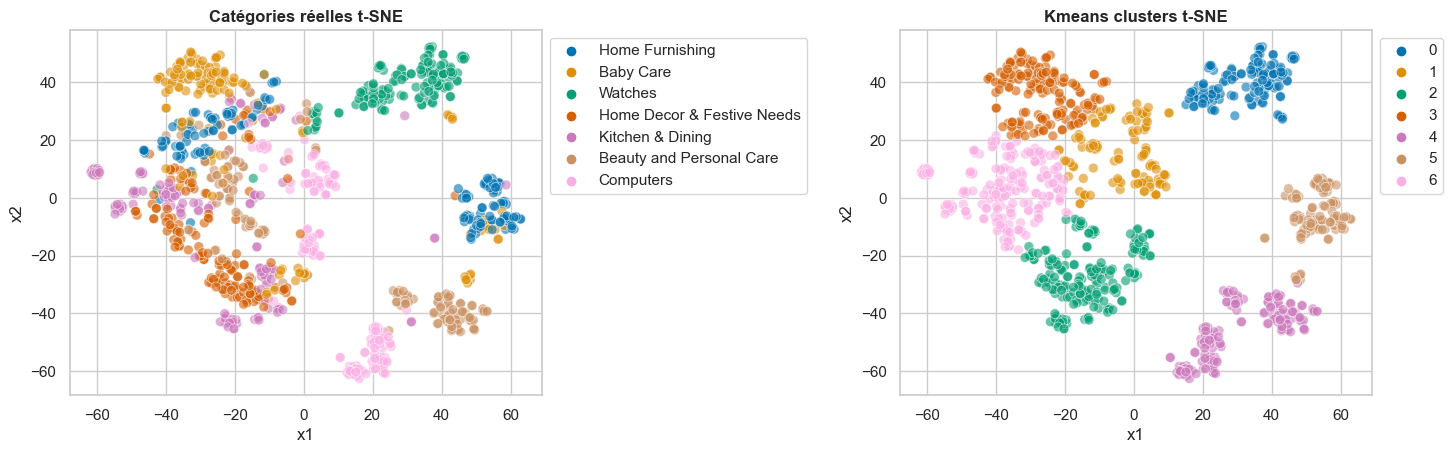

In [79]:
plot_tsne_clusters(X_tsne, clusters, categories_column)

#### Tensorflow hub

In [84]:
# Avec Tensorflow Hub
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

max_length = 356
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer
documents = data_to_vectorize['description_bow'].to_list()


# Création des features
features_bert_TH, last_hidden_states_tot = feature_BERT_fct(model, model_type, documents, 
                                                         max_length, batch_size, mode='TFhub')

100%|██████████| 105/105 [10:30<00:00,  6.00s/it]


temps de traitement :  631.0 s


In [85]:
features_bert_TH.shape

(1050, 768)

#### Fine tuning TSNE

In [86]:
fine_tune_tsne_parametre(PERPLEX, LR, cls=kmeans, train = features_bert_TH, to_array=False)

learning_rate  perplexity  TIME_      ARI_
5              10          21    7.0  0.312894
15             10          53   10.0  0.309525
6             257          21    6.0  0.308951
7             505          21    7.0  0.308632
8             752          21    7.0  0.308472
9            1000          21    7.0  0.306879
10             10          37    9.0  0.306753
14           1000          37    8.0  0.304605
13            752          37    9.0  0.304497
20             10          70   12.0  0.303806
11            257          37    9.0  0.301193
22            505          70   14.0  0.300600
17            505          53   10.0  0.299908
16            257          53    9.0  0.298688
21            257          70   12.0  0.297721
24           1000          70   11.0  0.296257
12            505          37    9.0  0.296107
18            752          53   10.0  0.291235
23            752          70   12.0  0.287304
19           1000          53    9.0  0.287219
3             752           5    6.0  0.280495
0              10           5    6.0  0.251217
2             505           5    6.0  0.246712
1             257           5    6.0  0.237418
4            1000           5    6.0  0.229474

In [103]:
ARI, X_tsne, clusters =  calcul_tsne_ari(features_bert_TH, pr_l = 21, lr_r=257, n_c=n_clusters, to_array=False, categories_column=categories_column)

ARI :  0.3108985746579752


#### Plot clusters

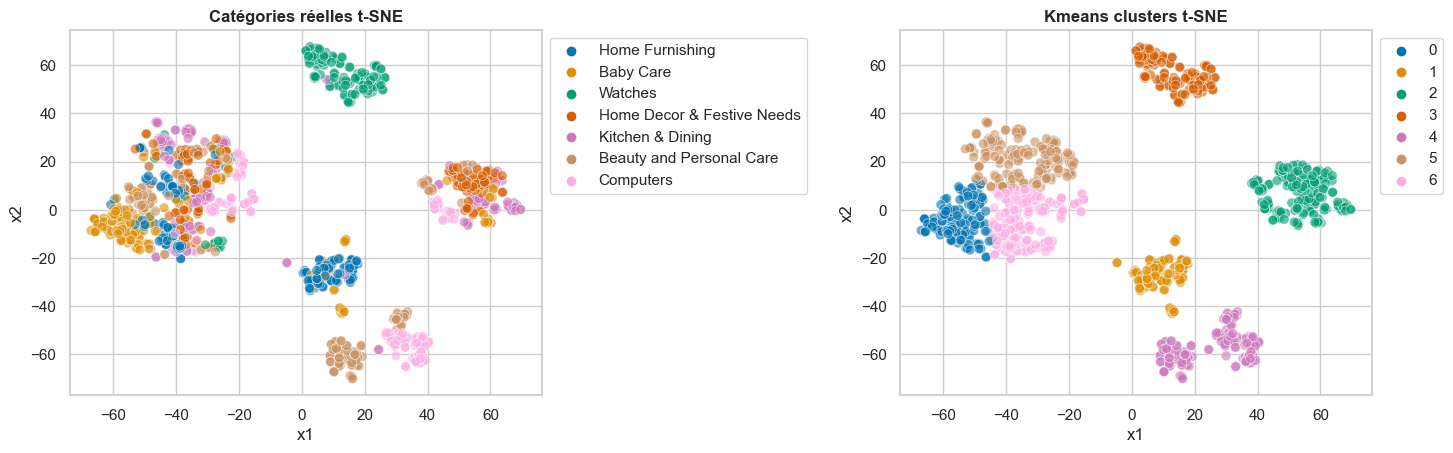

In [104]:
plot_tsne_clusters(X_tsne, clusters, categories_column)

### USE - Universal Sentence Encoder

In [62]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [63]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))
    return features

In [69]:
batch_size = 10
documents = data_to_vectorize['description_bow'].to_list()

In [73]:
with tf.device('/CPU:0'):
    features_USE = feature_USE_fct(documents, batch_size)

In [74]:
features_USE.shape

(1050, 512)

In [95]:
features_USE

array([[-0.05307089, -0.05326361,  0.01197454, ...,  0.0428762 ,
         0.04500521, -0.00728947],
       [-0.04960562, -0.04712431, -0.00868088, ...,  0.03171626,
         0.03275449,  0.01622683],
       [-0.05387859, -0.04699527, -0.02426139, ...,  0.05255282,
        -0.0344987 , -0.03834689],
       ...,
       [-0.02145761, -0.04973201, -0.00050752, ..., -0.01486797,
         0.05864152, -0.04792429],
       [-0.02196782, -0.05298935,  0.04468671, ...,  0.01089413,
        -0.02340357,  0.01104378],
       [-0.04147633, -0.04461837,  0.04057349, ...,  0.01761417,
        -0.02364889,  0.02464934]], dtype=float32)

#### Fine tuning TSNE

In [96]:
fine_tune_tsne_parametre(PERPLEX, LR, cls=kmeans, train = features_USE, to_array=False)

learning_rate  perplexity  TIME_      ARI_
6             257          21    7.0  0.427190
9            1000          21    7.0  0.426147
8             752          21    7.0  0.417091
5              10          21    7.0  0.411665
14           1000          37    9.0  0.407933
7             505          21    8.0  0.406820
18            752          53   11.0  0.405229
10             10          37    8.0  0.400823
1             257           5    6.0  0.394957
15             10          53   10.0  0.392106
13            752          37   10.0  0.391358
11            257          37    9.0  0.386947
24           1000          70   13.0  0.386593
21            257          70   12.0  0.385121
17            505          53   10.0  0.382904
19           1000          53   11.0  0.381613
23            752          70   12.0  0.381167
16            257          53   11.0  0.378409
12            505          37    9.0  0.378054
20             10          70   12.0  0.374711
22            505          70   13.0  0.371370
0              10           5    6.0  0.346920
2             505           5    7.0  0.331646
4            1000           5    6.0  0.320347
3             752           5    6.0  0.311220

In [101]:
ARI, X_tsne, clusters =  calcul_tsne_ari(features_USE, pr_l = 21, lr_r=257, n_c=n_clusters, to_array=False, categories_column=categories_column)

ARI :  0.4143485234249618


#### Plot clusters

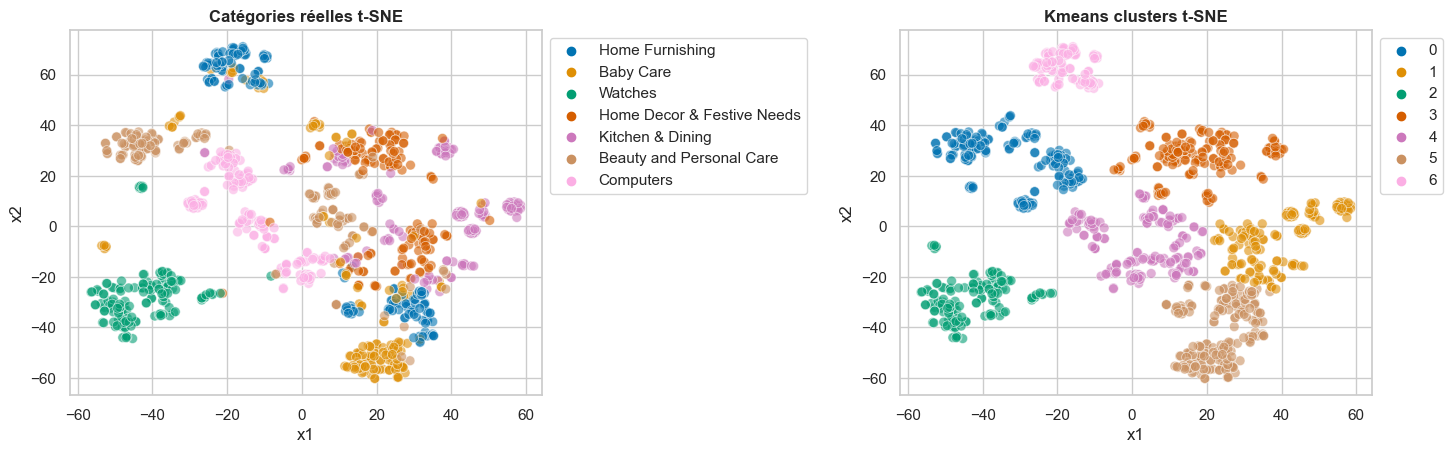

In [102]:
plot_tsne_clusters(X_tsne, clusters, categories_column)

In [108]:
os.path.abspath('data')

'C:\\Users\\Lenovo\\Documents\\DSPython\\P6_Classification\\data'